In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import corner
from matplotlib.colors import LogNorm
import scipy.optimize

In [2]:
# First read in the unvalidated GALAH DR4 file

setup = 'allstar'

galah_dr4_raw = Table.read('../catalogs/galah_dr4_'+setup+'_230206.fits')
galah_dr4_raw['source_id'] = galah_dr4_raw['gaiadr3_source_id']

accuracy_values = Table.read('../catalogs/galah_dr4_'+setup+'_accuracy.fits')

for label in ['teff','logg','fe_h','vmic','vsini','a_li']:
    if label not in accuracy_values.keys():
        accuracy_values[label] = 0.00
elements = [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu'
]
for element in elements:
    if element.lower()+'_fe' not in accuracy_values.keys():
        accuracy_values[element.lower()+'_fe'] = 0.00
if 'logg_spec' not in accuracy_values.keys():
    accuracy_values['logg_spec'] = 0.0
        
if setup == 'allspec':
    if np.isnan(galah_dr4_raw['e_logg'][0]):
        galah_dr4_raw['e_logg'] = 0.001
        
galah_dr4_raw['vrad'] = galah_dr4_raw['rv_comp_1']
galah_dr4_raw['e_vrad'] = galah_dr4_raw['e_rv_comp_1']
galah_dr4_raw['a_li'] = galah_dr4_raw['li_fe'] + galah_dr4_raw['fe_h'] + 1.05
galah_dr4_raw['e_a_li'] = galah_dr4_raw['e_li_fe']

# 1) Accuracy

# Gaia RV

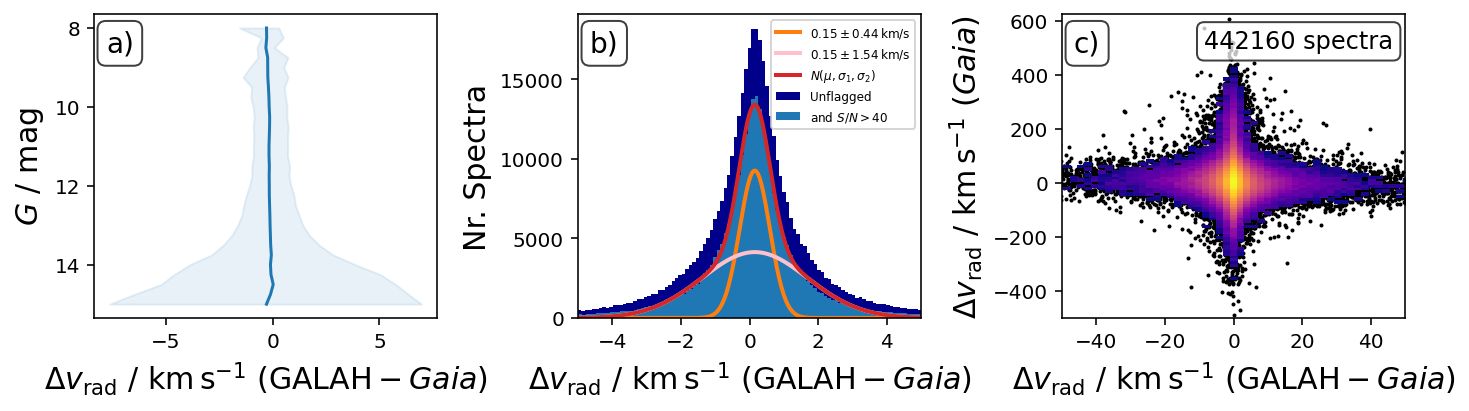

In [3]:
f, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10,3))

apply_flags = (
    (galah_dr4_raw['flag_sp'] == 0) &
#     (galah_dr4_raw['phot_g_mean_mag'] < 12) &
    np.isfinite(galah_dr4_raw['rv_gaia_dr3']) & 
    np.isfinite(galah_dr4_raw['rv_comp_1'])
    )

vrad_bins = np.arange(8,15.25,0.25)
vrad_step = 0.5*(vrad_bins[1]-vrad_bins[0])

vrad_gaia = []

for vrad_bin in vrad_bins:
    in_vrad_bin = (galah_dr4_raw['phot_g_mean_mag'] > vrad_bin-vrad_step) & (galah_dr4_raw['phot_g_mean_mag'] <= vrad_bin+vrad_step)
    if len(galah_dr4_raw['phot_g_mean_mag'][in_vrad_bin]) > 10:
        vrad_gaia.append(np.nanpercentile(galah_dr4_raw['rv_gaia_dr3'][in_vrad_bin] - galah_dr4_raw['rv_comp_1'][in_vrad_bin],q=[16,50,84]))
    else:
        vrad_gaia.append([np.nan,np.nan,np.nan])
        
vrad_gaia = np.array(vrad_gaia)
        
vrad_gaia_overall = np.nanpercentile(galah_dr4_raw['rv_gaia_dr3'] - galah_dr4_raw['rv_comp_1'],q=[16,50,84])

ax.plot(
    vrad_gaia[:,1],
    vrad_bins,
    c = 'C0',
    label = r'$\mathrm{GALAH~DR4} - Gaia~\mathrm{DR3}$'
)
ax.fill_betweenx(
    vrad_bins,
    vrad_gaia[:,0],
    vrad_gaia[:,2],
    alpha = 0.1,
    color = 'C0'
)
ax.set_ylabel(r'$G~/~\mathrm{mag}$',fontsize=15)
ax.set_xlabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(\mathrm{GALAH} - Gaia)$',fontsize=15)
ax.set_ylim(ax.get_ylim()[::-1])

ax1.hist(
    galah_dr4_raw['rv_comp_1'][apply_flags] - galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    bins = np.linspace(-5,5,100),
    color='darkblue',
    label=r'Unflagged'
)

ax2.scatter(
    galah_dr4_raw['rv_comp_1'][apply_flags] - galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    c='k',
    zorder=1,
    s=1,
)
ax2.hist2d(
    galah_dr4_raw['rv_comp_1'][apply_flags] - galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    bins = (np.linspace(-100,100,100),np.linspace(-500,500,100)),
    zorder=2,
    cmap='plasma',
    cmin=5,
    norm=LogNorm(),
    label=r'Unflagged'
);

stricter_flags = apply_flags & (galah_dr4_raw['snr_px_ccd2'] > 40)
first_median = np.median(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags])
first_mean = np.mean(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags])
first_std = np.std(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags])

def gauss_2(x,a1,x1,sigma1,a2,sigma2):
    return np.abs(a1)*np.exp(-(x-x1)**2/(2.*np.abs(sigma1)**2)) +  np.abs(a2)*np.exp(-(x-x1)**2/(2.*np.abs(sigma2)**2))

def gauss(x,a,x0,sigma):
    return np.abs(a)*np.exp(-(x-x0)**2/(2*sigma**2))


hist_bin, x, = np.histogram(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags], bins=np.linspace(-10,10,200))
bin_means = x[:-1]+0.5*(x[1]-x[0])

opt_parms, parm_cov = scipy.optimize.curve_fit(gauss_2,bin_means,hist_bin,p0=[10000, 0.21, 0.52, 3750, 1.50])

ax1.hist(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags],bins=np.linspace(-10,10,200),label=r'and $S/N > 40$',color='C0',lw=2)
ax1.plot(np.linspace(-10,10,1000),gauss(np.linspace(-10,10,1000),*opt_parms[:3]),label=r'$'+"{:.2f}".format(opt_parms[1])+'\pm'+"{:.2f}".format(opt_parms[2])+'\,\mathrm{km/s}$',color='C1',lw=2)
ax1.plot(np.linspace(-10,10,1000),gauss(np.linspace(-10,10,1000),*opt_parms[[3,1,4]]),label=r'$'+"{:.2f}".format(opt_parms[1])+'\pm'+"{:.2f}".format(opt_parms[4])+'\,\mathrm{km/s}$',color='pink',lw=2)
ax1.plot(np.linspace(-10,10,1000),gauss_2(np.linspace(-10,10,1000),*opt_parms),label=r'$N(\mu,\sigma_1,\sigma_2)$',c='C3',lw=2)

props = dict(boxstyle='round', facecolor='w', alpha=0.75)
ax.text(0.035, 0.95, 'a)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax1.text(0.035, 0.95, 'b)', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(0.035, 0.95, 'c)', transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(1-0.035, 0.95, str(len(galah_dr4_raw['rv_comp_1'][apply_flags]))+' spectra', transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', ha='right', bbox=props)

gaia_rv_gauss2_fit = r'$'+"{:.2f}".format(opt_parms[1])+'\pm'+"{:.2f}".format(opt_parms[2])+'\pm'+"{:.2f}".format(opt_parms[4])+'$'

ax1.set_xlim(-5,5)
ax2.set_ylim(-500,625)
ax2.set_xlim(-50,50)
ax1.legend(fontsize=6,loc='upper right')
ax1.set_xlabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(\mathrm{GALAH} - Gaia)$',fontsize=15)
ax1.set_ylabel(r'Nr. Spectra',fontsize=15)
ax2.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(Gaia)$',fontsize=15)
ax2.set_xlabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(\mathrm{GALAH} - Gaia)$',fontsize=15)
plt.tight_layout()
plt.savefig('figures/galah_dr4_vrad_gaia_dr3.png',dpi=200,bbox_inches='tight')

## Gaia FGK Benchmark Stars

In [4]:
gbs = Table.read('literature_data/GALAH_GBS2.1.fits')

gbs['sobject_id'][gbs['sobject_id']==150405000901378] = 210115002201239 # VESTA instead of skyflat
gbs['sobject_id'][gbs['sobject_id']==140209004701151] = 140207005401201 # eps Vir, 1 HighR 140208, 1 actual, 1 wrong fibre
gbs['sobject_id'][gbs['sobject_id']==140209005201151] = 140208004101201 # HD 122563, 1 HighR 140208, 1 actual, 1 wrong fibre
gbs['sobject_id'][gbs['sobject_id']==140808000901102] = 140208005101201 # HD 140283, 1 HighR 140208, 1 actual, 1 wrong fibre
gbs['sobject_id'][gbs['sobject_id']==140308003401188] = 140710002601284 # 18 Sco
gbs['sobject_id'][gbs['sobject_id']==140710000801284] = 140207004801201 # HD 107328

# Note: 141101003801339 # Procyon - not reduced

# Prepare [X/Fe]
for element in ['Mg','Si','Ca','Ti','Sc','V','Cr','Mn','Co','Ni']:
    gbs[element+'_fe'] = gbs['__'+element+'_H_'] - gbs['__Fe_H_']
    gbs['e_'+element+'_fe'] = np.sqrt(gbs['e__'+element+'_H_']**2 + gbs['e__Fe_H_']**2)

gbs_galah_match = []
galah_gbs_match = []

for index,each_gbs in enumerate(gbs['sobject_id']):
    if (setup != 'allstar') | (each_gbs not in [ # Do not look for repeat observations for *allstar*
        140710001701284, # Repeat ksi Hya
        140710002501284,140710003901284, # Repeat 18 Sco
        141231005201176, # Repeat HD 84937
        150204002101256, # Repeat mu Leo
        150210006401171, # Repeat eta Boo        
    ]): # Repeat observations
        side_a = np.where(
            galah_dr4_raw['sobject_id'] == each_gbs
        )[0]
        if len(side_a) > 0:
            print(each_gbs,gbs['StarID1'][index])
            gbs_galah_match.append(index)
            galah_gbs_match.append(side_a[0])
        else:
            print(each_gbs,'no')
# for each_sobject_id in range(len(galah_dr4_raw['sobject_id'])):
#     if galah_dr4_raw['sobject_id'][each_sobject_id] not in [140709001901194,150204002101256]:
#         try:
#             side_a = np.where(
#                     galah_dr4_raw['sobject_id'][each_sobject_id] == gbs['sobject_id']
#                 )[0][0]
#             side_b = each_sobject_id
#             gbs_galah_match.append(side_a)
#             galah_gbs_match.append(side_b)
#         except:
#             pass
gbs_galah_match = np.array(gbs_galah_match)
galah_gbs_match = np.array(galah_gbs_match)

comparison = Table()

comparison['GBS'] = gbs['StarID1'][gbs_galah_match]
comparison['sobject_id'] = gbs['sobject_id'][gbs_galah_match]
comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
comparison['teff_gbs'][comparison['teff_gbs'] < 0] = np.NaN
comparison['logg_gbs'] = gbs['logg'][gbs_galah_match]
comparison['fe_h_gbs'] = gbs['__Fe_H_'][gbs_galah_match]

comparison['fe_h_gbs'] = gbs['__Fe_H_'][gbs_galah_match]

comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])
comparison['e_logg_gbs'] = gbs['e_logg'][gbs_galah_match]
comparison['e_fe_h_gbs'] = gbs['e__Fe_H_'][gbs_galah_match]

comparison['teff'] = galah_dr4_raw['teff'][galah_gbs_match]
comparison['e_teff'] = galah_dr4_raw['e_teff'][galah_gbs_match]
comparison['logg'] = galah_dr4_raw['logg'][galah_gbs_match]
if setup == 'allstar':
    comparison['e_logg'] = 0.05 * np.ones(len(galah_dr4_raw['e_logg'][galah_gbs_match]))
else:
    comparison['e_logg'] = galah_dr4_raw['e_logg'][galah_gbs_match]
comparison['fe_h'] = galah_dr4_raw['fe_h'][galah_gbs_match]
comparison['e_fe_h'] = galah_dr4_raw['e_fe_h'][galah_gbs_match]

for element in ['Mg','Si','Ca','Ti','Sc','V','Cr','Mn','Co','Ni']:
    comparison[element+'_fe_gbs'] = gbs[element+'_fe'][gbs_galah_match]
    comparison['e_'+element+'_fe_gbs'] = gbs['e_'+element+'_fe'][gbs_galah_match]
    comparison[element+'_fe'] = galah_dr4_raw[element.lower()+'_fe'][galah_gbs_match]
    comparison['e_'+element+'_fe'] = galah_dr4_raw['e_'+element.lower()+'_fe'][galah_gbs_match]

comparison['flag_sp'] = galah_dr4_raw['flag_sp'][galah_gbs_match]

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

lbol_bias = {}

for each_param in ['teff','logg','fe_h']:
    good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs']) & (comparison['flag_sp'] < 32)
        )

    sigma = np.sqrt(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2)
    
    lbol_bias[each_param] = weighted_avg_and_std(
              comparison[each_param][good] - comparison[each_param+'_gbs'][good],
              1./(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2))
    
#     lbol_bias[each_param] = weighted_avg_and_std(
#               comparison[each_param][good] - comparison[each_param+'_gbs'][good],
#               np.min(sigma)/sigma)
    
good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs'])
        )

# comparison_old = comparison
# comparison = comparison[(np.isnan(comparison['teff_gbs']) | (abs(comparison['teff'] - comparison['teff_gbs']) < 400))]
comparison
lbol_bias

131216002601003 mu Leo   
131216003201003 HD 84937 
131220004401099 ksi Hya  
140207005401201 eps Vir  
140208004101201 HD 122563
140710002601284 18 Sco   
140708003401078 mu Ara   
140708005801203 bet Hyi  
140708006401203 tau Cet  
140709001901194 eta Boo  
140709004401117 gam Sge  
140207004801201 HD 107328
140710006601104 alf Cet  
140710007601032 eps Eri  
140710008301032 del Eri  
140710009001032 HD 22879 
140806005301134 eps For  
140208005101201 HD 140283
141101003801339 no
141102003801353 alf Tau  
141102004001353 HD 49933 
150210005801171 Arcturus 
210115002201239 Sun      


<ipython-input-4-8f1cee5c17cd>:55: UserWarning: Warning: converting a masked element to nan.
  comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
<ipython-input-4-8f1cee5c17cd>:62: UserWarning: Warning: converting a masked element to nan.
  comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])


{'teff': (20.65745921148739, 92.49611081000232),
 'logg': (-0.010756759366841707, 0.05935681103116618),
 'fe_h': (0.003716099, 0.067084014)}

## Asteroseismic Information

In [5]:
# Zinn et al. 2022: https://ui.adsabs.harvard.edu/abs/2022ApJ...926..191Z
zinn_table2 = Table.read('../auxiliary_information/Zinn2021_asteroseismic_values/Zinn_2022_ApJ_926_191_Table2_GaiaDR2_1arsec_xmatch_GALAH_DR4_230101.fits')
zinn_table6 = Table.read('../auxiliary_information/Zinn2021_asteroseismic_values/Zinn_2022_ApJ_926_191_Table6_GaiaDR2_1arsec_xmatch_GALAH_DR4_230101.fits')
seismic_k2 = join(zinn_table2,zinn_table6,keys='sobject_id',join_type='inner',metadata_conflicts='silent')
seismic_k2['source_id'] = seismic_k2['source_id_1']
seismic_tess = Table.read('../auxiliary_information/Hon2021_asteroseismic_values/apjac14b1t1_220902.fits')

# Hon et al. 2021: https://ui.adsabs.harvard.edu/abs/2021ApJ...919..131H
seismic_k2_galahdr4 = join(galah_dr4_raw,seismic_k2,keys='source_id',metadata_conflicts='silent')
seismic_k2_galahdr4['k2_tic'] = np.array(['k2' for x in range(len(seismic_k2_galahdr4['sobject_id_1']))])
seismic_tess_galahdr4 = join(galah_dr4_raw,seismic_tess,keys='tmass_id',metadata_conflicts='silent')
seismic_tess_galahdr4['k2_tic'] = np.array(['tess' for x in range(len(seismic_tess_galahdr4['sobject_id_1']))])

# Stack them and compute spectroscopic NUMAX and asteroseismic LOGG
galah_dr4_seismic = vstack([seismic_k2_galahdr4,seismic_tess_galahdr4],metadata_conflicts='silent')
galah_dr4_seismic['nu_max_model'] = (10**galah_dr4_seismic['logg']) / (10**4.438) * np.sqrt(galah_dr4_seismic['teff'] / 5772.) * 3090.
galah_dr4_seismic['logg_seis'] = np.log10(galah_dr4_seismic['numax'] / 3090. * (10**4.438) * np.sqrt(galah_dr4_seismic['teff'] / 5772.))

## APOGEE

In [6]:
# Then read in APOGEE DR17
apogee_dr17 = Table.read('../../Surveys/APOGEE_DR17/allStar-dr17-synspec_rev1.fits',1)
apogee_dr17['tmass_id'] = np.array([str(x)[2:] for x in apogee_dr17['APOGEE_ID']])
apogee_dr17['tmass_id'][0] = 'VESTA'

galah_dr4_apogee_dr17 = join(galah_dr4_raw, apogee_dr17, keys='tmass_id')
apply_quality_cuts = (
        np.isfinite(galah_dr4_apogee_dr17['teff']) &
        np.isfinite(galah_dr4_apogee_dr17['TEFF']) &
        np.isfinite(galah_dr4_apogee_dr17['logg']) &
        np.isfinite(galah_dr4_apogee_dr17['LOGG']) &
        np.isfinite(galah_dr4_apogee_dr17['fe_h']) &
        np.isfinite(galah_dr4_apogee_dr17['FE_H'])
    )
galah_dr4_apogee_dr17 = galah_dr4_apogee_dr17[apply_quality_cuts]

## COMBINE EVERYTHING

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


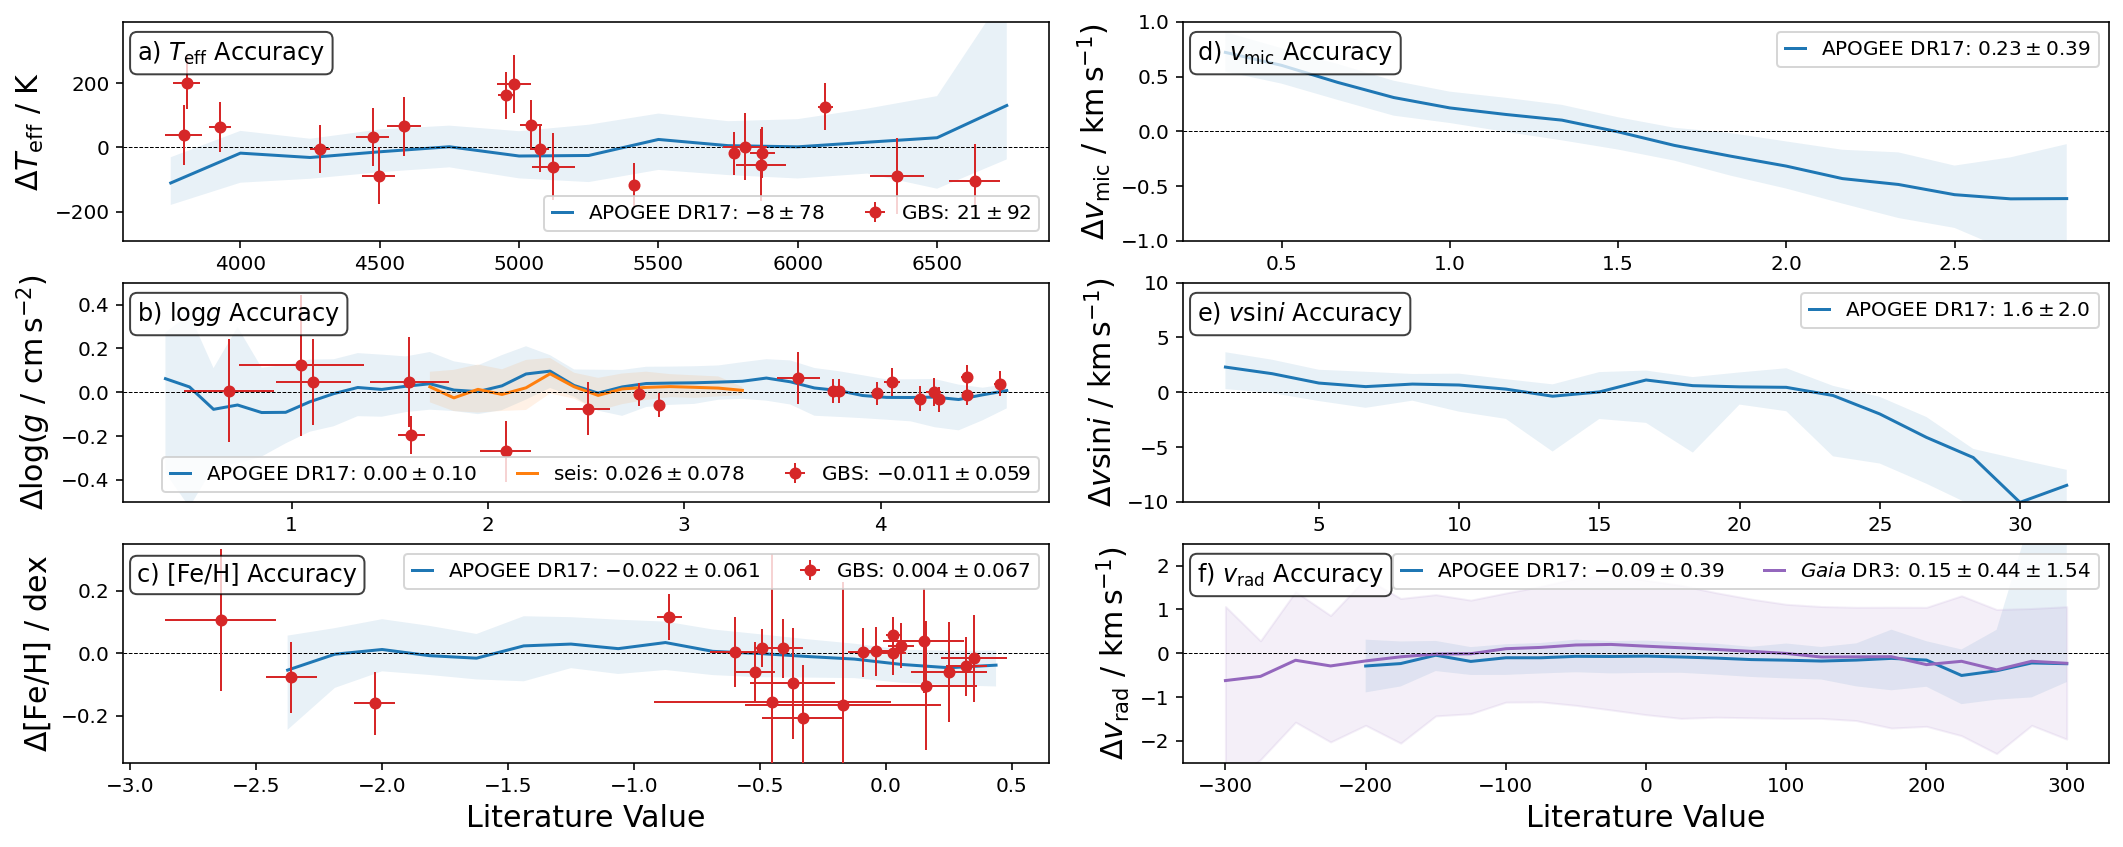

In [7]:
f, gs = plt.subplots(3,2,figsize=(15,6))

apo_use = (
    (galah_dr4_apogee_dr17['flag_sp'] == 0) &
    (galah_dr4_apogee_dr17['ASPCAPFLAG'] < 25231360)
)

"""
TEFF ACCURACY
"""

ax = gs[0,0]
ax.text(0.015,0.825,r'a) $T_\mathrm{eff}$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

# GBS TEFF

flagged = ~(comparison['flag_sp'] < 32)# & (comparison['logg'] > 2.5)

ax.errorbar(
    comparison['teff_gbs'],
    comparison['teff'] - comparison['teff_gbs'],
    xerr = comparison['e_teff_gbs'],
    yerr = np.sqrt(comparison['e_teff_gbs']**2 + comparison['e_teff']**2),
    fmt = 'o', lw=1,ms=5,
    label=r'GBS: $'+str('%.0f' % lbol_bias['teff'][0])+' \pm '+str('%.0f' % lbol_bias['teff'][1])+'$',
    zorder=3,c='C3',
    )

# OTHER TEFF

teff_bins = np.linspace(3000,8000,21)
teff_step = 0.5*(teff_bins[1]-teff_bins[0])

teff_apogee = []

for teff_bin in teff_bins:
    in_teff_bin = (galah_dr4_apogee_dr17['TEFF'][apo_use] > teff_bin-teff_step) & (galah_dr4_apogee_dr17['TEFF'][apo_use] <= teff_bin+teff_step)
    if len(galah_dr4_apogee_dr17['teff'][apo_use][in_teff_bin]) > 10:
        teff_apogee.append(np.percentile(galah_dr4_apogee_dr17['teff'][apo_use][in_teff_bin] - galah_dr4_apogee_dr17['TEFF'][apo_use][in_teff_bin],q=[16,50,84]))
    else:
        teff_apogee.append([np.nan,np.nan,np.nan])
        
teff_apogee = np.array(teff_apogee)
        
teff_apogee_overall = np.array(np.round(np.nanpercentile(galah_dr4_apogee_dr17['teff'][apo_use] - galah_dr4_apogee_dr17['TEFF'][apo_use],q=[16,50,84]),0),dtype=int)

ax.plot(
    teff_bins,
    teff_apogee[:,1],
    label = r'APOGEE DR17: $'+str(teff_apogee_overall[1])+' \pm '+str(teff_apogee_overall[1]-teff_apogee_overall[0])+'}^{+'+str(teff_apogee_overall[2]-teff_apogee_overall[1])+'}$'
)
ax.fill_between(
    teff_bins,
    teff_apogee[:,0],
    teff_apogee[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='lower right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-290,390)


"""
LOGG ACCURACY
"""
ax = gs[1,0]
ax.text(0.015,0.825,r'b) $\log g$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

# GBS LOGG

ax.errorbar(
    comparison['logg_gbs'],
    comparison['logg'] - comparison['logg_gbs'],
    xerr = comparison['e_logg_gbs'],
    yerr = np.sqrt(comparison['e_logg_gbs']**2 + comparison['e_logg']**2),
    fmt = 'o', lw=1,ms=5, zorder=3,c='C3',
    label=r'GBS: $'+str('%.3f' % lbol_bias['logg'][0])+' \pm '+str('%.3f' % lbol_bias['logg'][1])+'$',
    )

# OTHER LOGG

logg_bins = np.linspace(-0.5,5.5,50)
logg_step = 0.5*(logg_bins[1]-logg_bins[0])

logg_apogee = []

for logg_bin in logg_bins:
    in_logg_bin = (galah_dr4_apogee_dr17['LOGG'][apo_use] > logg_bin-logg_step) & (galah_dr4_apogee_dr17['LOGG'][apo_use] <= logg_bin+logg_step)
    if len(galah_dr4_apogee_dr17['logg'][apo_use][in_logg_bin]) > 10:
        logg_apogee.append(np.percentile(galah_dr4_apogee_dr17['logg'][apo_use][in_logg_bin] - galah_dr4_apogee_dr17['LOGG'][apo_use][in_logg_bin],q=[16,50,84]))
    else:
        logg_apogee.append([np.nan,np.nan,np.nan])
        
logg_apogee = np.array(logg_apogee)
        
logg_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['logg'][apo_use] - galah_dr4_apogee_dr17['LOGG'][apo_use],q=[16,50,84])
    
ax.plot(
    logg_bins,
    logg_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.2f}".format(logg_apogee_overall[1])+' \pm '+"{:.2f}".format(0.5*(logg_apogee_overall[2]-logg_apogee_overall[0]))+'$'
)
ax.fill_between(
    logg_bins,
    logg_apogee[:,0],
    logg_apogee[:,2],
    alpha = 0.1
)

logg_seismic = []

for logg_bin in logg_bins:
    in_logg_bin = (galah_dr4_seismic['logg_seis'] > logg_bin-logg_step) & (galah_dr4_seismic['logg_seis'] <= logg_bin+logg_step)
    if len(galah_dr4_seismic['logg'][in_logg_bin]) > 10:
        logg_seismic.append(np.percentile(galah_dr4_seismic['logg'][in_logg_bin] - galah_dr4_seismic['logg_seis'][in_logg_bin],q=[16,50,84]))
    else:
        logg_seismic.append([np.nan,np.nan,np.nan])
        
logg_seismic = np.array(logg_seismic)
        
logg_seismic_overall = np.nanpercentile(galah_dr4_seismic['logg'] - galah_dr4_seismic['logg_seis'],q=[16,50,84])
    
ax.plot(
    logg_bins,
    logg_seismic[:,1],
    label = r'seis: $'+"{:.3f}".format(logg_seismic_overall[1])+' \pm '+"{:.3f}".format(0.5*(logg_seismic_overall[2]-logg_seismic_overall[0]))+'$'
)
ax.fill_between(
    logg_bins,
    logg_seismic[:,0],
    logg_seismic[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta \log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='lower right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-0.5,0.5)


"""
FE_H ACCURACY
"""
ax = gs[2,0]
ax.text(0.015,0.825,r'c) [Fe/H] Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

# GBS [Fe/H]

ax.errorbar(
    comparison['fe_h_gbs'],
    comparison['fe_h'] - comparison['fe_h_gbs'],
    xerr = comparison['e_fe_h_gbs'],
    yerr = np.sqrt(comparison['e_fe_h_gbs']**2 + comparison['e_fe_h']**2),
    fmt = 'o', lw=1,ms=5, zorder=3,c='C3',
    label=r'GBS: $'+str('%.3f' % lbol_bias['fe_h'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h'][1])+'$',
    )

# OTHER FEH

fe_h_bins = np.linspace(-3.5,1.0,25)
fe_h_step = 0.5*(fe_h_bins[1]-fe_h_bins[0])

fe_h_apogee = []

for fe_h_bin in fe_h_bins:
    in_fe_h_bin = (galah_dr4_apogee_dr17['FE_H'][apo_use] > fe_h_bin-fe_h_step) & (galah_dr4_apogee_dr17['FE_H'][apo_use] <= fe_h_bin+fe_h_step)
    if len(galah_dr4_apogee_dr17['fe_h'][apo_use][in_fe_h_bin]) > 10:
        fe_h_apogee.append(np.percentile(galah_dr4_apogee_dr17['fe_h'][apo_use][in_fe_h_bin] - galah_dr4_apogee_dr17['FE_H'][apo_use][in_fe_h_bin],q=[16,50,84]))
    else:
        fe_h_apogee.append([np.nan,np.nan,np.nan])
        
fe_h_apogee = np.array(fe_h_apogee)

fe_h_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['fe_h'][apo_use] - galah_dr4_apogee_dr17['FE_H'][apo_use],q=[16,50,84])

ax.plot(
    fe_h_bins,
    fe_h_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.3f}".format(fe_h_apogee_overall[1])+' \pm '+"{:.3f}".format(0.5*(fe_h_apogee_overall[2]-fe_h_apogee_overall[0]))+'$'
)
ax.fill_between(
    fe_h_bins,
    fe_h_apogee[:,0],
    fe_h_apogee[:,2],
    alpha = 0.1
)

ax.set_xlabel(r'Literature Value',fontsize=15)
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='upper right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-0.35,0.35)


"""
VMIC ACCURACY
"""
ax = gs[0,1]
ax.text(0.015,0.825,r'd) $v_\mathrm{mic}$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

vmic_bins = np.linspace(0,4,25)
vmic_step = 0.5*(vmic_bins[1]-vmic_bins[0])

vmic_apogee = []

for vmic_bin in vmic_bins:
    in_vmic_bin = (galah_dr4_apogee_dr17['VMICRO'][apo_use] > vmic_bin-vmic_step) & (galah_dr4_apogee_dr17['VMICRO'][apo_use] <= vmic_bin+vmic_step)
    if len(galah_dr4_apogee_dr17['vmic'][apo_use][in_vmic_bin]) > 10:
        vmic_apogee.append(np.percentile(galah_dr4_apogee_dr17['vmic'][apo_use][in_vmic_bin] - galah_dr4_apogee_dr17['VMICRO'][apo_use][in_vmic_bin],q=[16,50,84]))
    else:
        vmic_apogee.append([np.nan,np.nan,np.nan])
        
vmic_apogee = np.array(vmic_apogee)
        
vmic_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['vmic'][apo_use] - galah_dr4_apogee_dr17['VMICRO'][apo_use],q=[16,50,84])
    
ax.plot(
    vmic_bins,
    vmic_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.2f}".format(vmic_apogee_overall[1])+' \pm '+"{:.2f}".format(0.5*(vmic_apogee_overall[2]-vmic_apogee_overall[0]))+'$'
)
ax.fill_between(
    vmic_bins,
    vmic_apogee[:,0],
    vmic_apogee[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta v_\mathrm{mic}~/~\mathrm{km\,s^{-1}})$',fontsize=15)
ax.set_ylim(-1,1)
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='upper right')

"""
vsini ACCURACY
"""
ax = gs[1,1]
ax.text(0.015,0.825,r'e) $v \sin i$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

vsini_bins = np.linspace(0,40,25)
vsini_step = 0.5*(vsini_bins[1]-vsini_bins[0])

vsini_apogee = []

for vsini_bin in vsini_bins:
    in_vsini_bin = (galah_dr4_apogee_dr17['VSINI'][apo_use] > vsini_bin-vsini_step) & (galah_dr4_apogee_dr17['VSINI'][apo_use] <= vsini_bin+vsini_step)
    if len(galah_dr4_apogee_dr17['vsini'][apo_use][in_vsini_bin]) > 10:
        vsini_apogee.append(np.percentile(galah_dr4_apogee_dr17['vsini'][apo_use][in_vsini_bin] - galah_dr4_apogee_dr17['VSINI'][apo_use][in_vsini_bin],q=[16,50,84]))
    else:
        vsini_apogee.append([np.nan,np.nan,np.nan])
        
vsini_apogee = np.array(vsini_apogee)
        
vsini_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['vsini'][apo_use] - galah_dr4_apogee_dr17['VSINI'][apo_use],q=[16,50,84])

ax.plot(
    vsini_bins,
    vsini_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.1f}".format(vsini_apogee_overall[1])+' \pm '+"{:.1f}".format(vsini_apogee_overall[1]-vsini_apogee_overall[0])+'}^{+'+"{:.2f}".format(vsini_apogee_overall[2]-vsini_apogee_overall[1])+'}$'
)
ax.fill_between(
    vsini_bins,
    vsini_apogee[:,0],
    vsini_apogee[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta v \sin i~/~\mathrm{km\,s^{-1}})$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='upper right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-10,10)

"""
vrad ACCURACY
"""
ax = gs[2,1]
ax.text(0.015,0.825,r'f) $v_\mathrm{rad}$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

vrad_bins = np.linspace(-300,300,25)
vrad_step = 0.5*(vrad_bins[1]-vrad_bins[0])

vrad_apogee = []

for vrad_bin in vrad_bins:
    in_vrad_bin = (galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use] > vrad_bin-vrad_step) & (galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use] <= vrad_bin+vrad_step)
    if len(galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use][in_vrad_bin]) > 10:
        vrad_apogee.append(np.percentile(galah_dr4_apogee_dr17['rv_comp_1'][apo_use][in_vrad_bin] - galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use][in_vrad_bin],q=[16,50,84]))
    else:
        vrad_apogee.append([np.nan,np.nan,np.nan])

vrad_apogee = np.array(vrad_apogee)
        
vrad_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['rv_comp_1'][apo_use] - galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use],q=[16,50,84])

ax.plot(
    vrad_bins,
    vrad_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.2f}".format(vrad_apogee_overall[1])+' \pm '+"{:.2f}".format(vrad_apogee_overall[1]-vrad_apogee_overall[0])+'}^{+'+"{:.2f}".format(vrad_apogee_overall[2]-vrad_apogee_overall[1])+'}$'
)
ax.fill_between(
    vrad_bins,
    vrad_apogee[:,0],
    vrad_apogee[:,2],
    alpha = 0.1
)

vrad_gaia = []

use = (galah_dr4_raw['flag_sp'] == 0)

for vrad_bin in vrad_bins:
    in_vrad_bin = (galah_dr4_raw['rv_gaia_dr3'][use] > vrad_bin-vrad_step) & (galah_dr4_raw['rv_gaia_dr3'][use] <= vrad_bin+vrad_step)
    if len(galah_dr4_raw['rv_gaia_dr3'][use][in_vrad_bin]) > 10:
        vrad_gaia.append(np.nanpercentile(galah_dr4_raw['rv_comp_1'][use][in_vrad_bin] - galah_dr4_raw['rv_gaia_dr3'][use][in_vrad_bin],q=[16,50,84]))
    else:
        vrad_gaia.append([np.nan,np.nan,np.nan])
        
vrad_gaia = np.array(vrad_gaia)
        
vrad_gaia_overall = np.nanpercentile(galah_dr4_raw['rv_comp_1'][use] - galah_dr4_raw['rv_gaia_dr3'][use],q=[16,50,84])

ax.plot(
    vrad_bins,
    vrad_gaia[:,1],
    c = 'C4',
    #label = r'$Gaia$ DR3: $'+"{:.2f}".format(vrad_gaia_overall[1])+' \pm '+"{:.2f}".format(vrad_gaia_overall[1]-vrad_gaia_overall[0])+'}^{+'+"{:.2f}".format(vrad_gaia_overall[2]-vrad_gaia_overall[1])+'}$'
    # We have actually calculated the Gaia DR3 RV difference with a more robust approach (against binaries)
    label = r'$Gaia$ DR3: '+gaia_rv_gauss2_fit
)
ax.fill_between(
    vrad_bins,
    vrad_gaia[:,0],
    vrad_gaia[:,2],
    alpha = 0.1,
    color = 'C4'
)

ax.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}})$',fontsize=15)
ax.set_xlabel(r'Literature Value',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3)
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-2.5,2.5)

plt.tight_layout(h_pad=0)
plt.savefig('figures/galah_dr4_validation_parameter_accuracy_'+setup+'.png',dpi=200,bbox_inches='tight')

# Solar twins

In [8]:
def gce_function(age,each_element):
    return GCE_trends[each_element][0]*age+GCE_trends[each_element][2]

GCE_trends = dict() # m*age+b
GCE_trends['C']   = [0.0115 , 0.0014 ,-0.0836 , 0.0089 ,0.0394 , 0.0044]
GCE_trends['CH']  = [0.0115 , 0.0014 ,-0.0940 , 0.0079 ,0.0293 , 0.0030]
GCE_trends['O']   = [0.0088 , 0.0014 ,-0.0260 , 0.0075 ,0.0238 , 0.0028]
GCE_trends['Na']  = [0.0086 , 0.0016 ,-0.0614 , 0.0089 ,0.0273 , 0.0029]
GCE_trends['Mg']  = [0.0099 , 0.0009 ,-0.0367 , 0.0048 ,0.0121 , 0.0018]
GCE_trends['Al']  = [0.0139 , 0.0010 ,-0.0595 , 0.0054 ,0.0156 , 0.0019]
GCE_trends['Si']  = [0.0063 , 0.0006 ,-0.0308 , 0.0033 ,0.0110 , 0.0011]
GCE_trends['S']   = [0.0098 , 0.0015 ,-0.0537 , 0.0085 ,0.0240 , 0.0035]
GCE_trends['Ca']  = [-0.0011,  0.0006, 0.0217 , 0.0032 ,0.0089 , 0.0011]
GCE_trends['Sc']  = [0.0059 , 0.0009 ,-0.0263 , 0.0052 ,0.0159 , 0.0022]
GCE_trends['Sc2'] = [0.0059 , 0.0009 ,-0.0235 , 0.0052 ,0.0205 , 0.0025]
GCE_trends['Ti']  = [0.0036 , 0.0005 ,-0.0024 , 0.0032 ,0.0119 , 0.0014]
GCE_trends['Ti2'] = [0.0036 , 0.0005 ,-0.0094 , 0.0031 ,0.0115 , 0.0014]
GCE_trends['V']   = [0.0013 , 0.0007 ,-0.0023 , 0.0037 ,0.0091 , 0.0011]
GCE_trends['Cr']  = [-0.0016, 0.0003 ,0.0095  , 0.0019 ,0.0053 , 0.0008]
GCE_trends['Cr2'] = [-0.0016, 0.0003 ,0.0133  , 0.0019 ,0.0000 , 0.0001]
GCE_trends['Mn']  = [0.0023 , 0.0012 ,-0.0312 , 0.0063 ,0.0206 , 0.0020]
GCE_trends['Co']  = [0.0074 , 0.0011 ,-0.0460 , 0.0057 ,0.0178 , 0.0020]
GCE_trends['Ni']  = [0.0071 , 0.0009 ,-0.0505 , 0.0050 ,0.0172 , 0.0018]
GCE_trends['Cu']  = [0.0149 , 0.0017 ,-0.0850 , 0.0097 ,0.0244 , 0.0030]
GCE_trends['Zn']  = [0.0102 , 0.0014 ,-0.0699 , 0.0077 ,0.0224 , 0.0029]
GCE_trends['Sr']  = [-0.0251 , 0.0030, 0.1310 , 0.0164 ,0.0574 , 0.0060]
GCE_trends['Y']   = [-0.0238 , 0.0024, 0.1135 , 0.0130 ,0.0470 , 0.0051]
GCE_trends['Zr']  = [-0.0219 , 0.0023, 0.1179 , 0.0125 ,0.0422 , 0.0046]
GCE_trends['Ba']  = [-0.0317 , 0.0018, 0.1897 , 0.0093 ,0.0309 , 0.0039]
GCE_trends['La']  = [-0.0227 , 0.0021, 0.1397 , 0.0121 ,0.0350 , 0.0046]
GCE_trends['Ce']  = [-0.0220 , 0.0018, 0.1497 , 0.0097 ,0.0305 , 0.0039]
GCE_trends['Pr']  = [-0.0103 , 0.0025, 0.1534 , 0.0131 ,0.0451 , 0.0050]
GCE_trends['Nd']  = [-0.0198 , 0.0020, 0.1527 , 0.0108 ,0.0360 , 0.0038]
GCE_trends['Sm']  = [-0.0077 , 0.0017, 0.0668 , 0.0094 ,0.0226 , 0.0032]
GCE_trends['Eu']  = [-0.0056 , 0.0017, 0.0908 , 0.0093 ,0.0300 , 0.0033]
GCE_trends['Gd']  = [-0.0060 , 0.0016, 0.0592 , 0.0089 ,0.0279 , 0.0028]
GCE_trends['Dy']  = [-0.0073 , 0.0023, 0.0805 , 0.0123 ,0.0332 , 0.0043]

In [9]:
def plot_xfe_vs_age(ax, each_element, xfe_range=[-0.5,1.5], age_bins = np.linspace(0,12.5,50)):

    flag_max = 0
    if each_element in ['C','N']:
        flag_max = 32
    
    solar_twins = (
        (np.abs(galah_dr4_raw['teff'] - 5772) < 100) &
        (np.abs(galah_dr4_raw['logg'] - 4.438) < 0.1) &
        (np.abs(galah_dr4_raw['fe_h'] - 0.00) < 0.1) & 
        (galah_dr4_raw['flag_sp'] == 0) &
        (galah_dr4_raw['snr_px_ccd2'] > 40) &
        (galah_dr4_raw['flag_'+each_element.lower()+'_fe'] <= flag_max) &
        np.isfinite(galah_dr4_raw[each_element.lower()+'_fe']) &
        np.isfinite(galah_dr4_raw['age'])&
        np.abs(galah_dr4_raw[each_element.lower()+'_fe'] < 0.3)
    )
    
    def linear_function(x, slope, bias):
        return(slope * x + bias)
    
    print(each_element)
    
    if len(galah_dr4_raw['age'][solar_twins]) > 5:

        age_xfe = np.array(galah_dr4_raw['age'][solar_twins])

        abundance_ratio = each_element.lower()+'_fe'

        opt_parms, parm_cov = scipy.optimize.curve_fit(
            linear_function,
            xdata = age_xfe,
            ydata = galah_dr4_raw[abundance_ratio][solar_twins],
            sigma = galah_dr4_raw['e_'+abundance_ratio][solar_twins],
            p0=[0,0]
        )
        
        ax.hist2d(
            age_xfe,
            galah_dr4_raw[abundance_ratio][solar_twins],
            bins = (
                age_bins,
                np.linspace(xfe_range[0],xfe_range[1],50)
            ),
            cmin=1,cmap='Blues_r'        
        )
        
        if opt_parms[1] >= 0:
            func_label = r'DR4: $'+"{:.3f}".format(opt_parms[0])+' \cdot \mathrm{Age} + '+"{:.3f}".format(opt_parms[1])+'$'
        else:
            func_label = r'DR4: $'+"{:.3f}".format(opt_parms[0])+' \cdot \mathrm{Age} '+"{:.3f}".format(opt_parms[1])+'$'
        
        print('DR4: '+"{:.3f}".format(opt_parms[0]*4.5 + opt_parms[1]))
        
        ax.plot(
            age_bins,
            linear_function(age_bins,*opt_parms),
            c = 'C1',
            label = func_label
        )
        
    if each_element in GCE_trends.keys():
        if GCE_trends[each_element][2] >= 0:
            func_label = r'B18: $'+"{:.3f}".format(GCE_trends[each_element][0])+' \cdot \mathrm{Age} + '+"{:.3f}".format(GCE_trends[each_element][2])+'$'
        else:
            func_label = r'B18: $'+"{:.3f}".format(GCE_trends[each_element][0])+' \cdot \mathrm{Age} '+"{:.3f}".format(GCE_trends[each_element][2])+'$'
        
        print('B18: '+"{:.3f}".format(GCE_trends[each_element][0]*4.5 + GCE_trends[each_element][2]))
        
        ax.plot(age_bins,gce_function(age_bins,each_element),c='C3',label = func_label)
        if len(galah_dr4_raw['age'][solar_twins]) > 5:
            difference = galah_dr4_raw[abundance_ratio][solar_twins] - gce_function(age_xfe,each_element)
            perc = np.percentile(difference,q=[16,50,84])
            if (0.5*(perc[2]-perc[0])) >= 0.095:
                fmt = "{:.2f}"
            else:
                fmt = "{:.3f}"
            ax.text(0.035,0.95,each_element+r': $'+fmt.format(perc[1])+'\pm'+fmt.format(0.5*(perc[2]-perc[0]))+'$',transform=ax.transAxes,va='top', bbox=dict(boxstyle='round', facecolor='w', alpha=0.95),fontsize=13)
        else:
            perc = [np.nan,np.nan,np.nan]
            ax.text(0.035,0.95,each_element,transform=ax.transAxes,va='top', bbox=dict(boxstyle='round', facecolor='w', alpha=0.95),fontsize=13)
    else:
        perc = [np.nan,np.nan,np.nan]
        ax.text(0.035,0.95,each_element,transform=ax.transAxes,va='top', bbox=dict(boxstyle='round', facecolor='w', alpha=0.95),fontsize=13)
    ax.set_ylim(xfe_range[0],xfe_range[1])
    ax.legend(fontsize=6,handlelength=1,columnspacing=0,loc = 'lower right',framealpha=0.9)
    
    try:
        print('Diff '+"{:.3f}".format(opt_parms[0]*4.5 + opt_parms[1] - (GCE_trends[each_element][0]*4.5 + GCE_trends[each_element][2])))
    except:
        pass
        
    return(perc)


C
DR4: -0.035
B18: -0.032
Diff -0.003
O
DR4: 0.011
B18: 0.014
Diff -0.003
Na
DR4: -0.026
B18: -0.023
Diff -0.003
Mg
DR4: -0.011
B18: 0.008
Diff -0.019
Al
DR4: -0.064
B18: 0.003
Diff -0.067
Si
DR4: -0.016
B18: -0.002
Diff -0.014
K
DR4: -0.016
Ca
DR4: -0.023
B18: 0.017
Diff -0.040
Sc
DR4: -0.024
B18: 0.000
Diff -0.024
Ti
DR4: -0.015
B18: 0.014
Diff -0.029
V
DR4: -0.044
B18: 0.004
Diff -0.047
Cr
DR4: -0.006
B18: 0.002
Diff -0.008
Mn
DR4: -0.002
B18: -0.021
Diff 0.019
Co
DR4: -0.057
B18: -0.013
Diff -0.044
Ni
DR4: -0.016
B18: -0.019
Diff 0.003
Cu
DR4: -0.058
B18: -0.018
Diff -0.040
Zn
DR4: -0.034
B18: -0.024
Diff -0.010
Y
DR4: 0.006
B18: 0.006
Diff -0.001
Ba
DR4: 0.037
B18: 0.047
Diff -0.010
Nd
DR4: -0.029
B18: 0.064
Diff -0.092


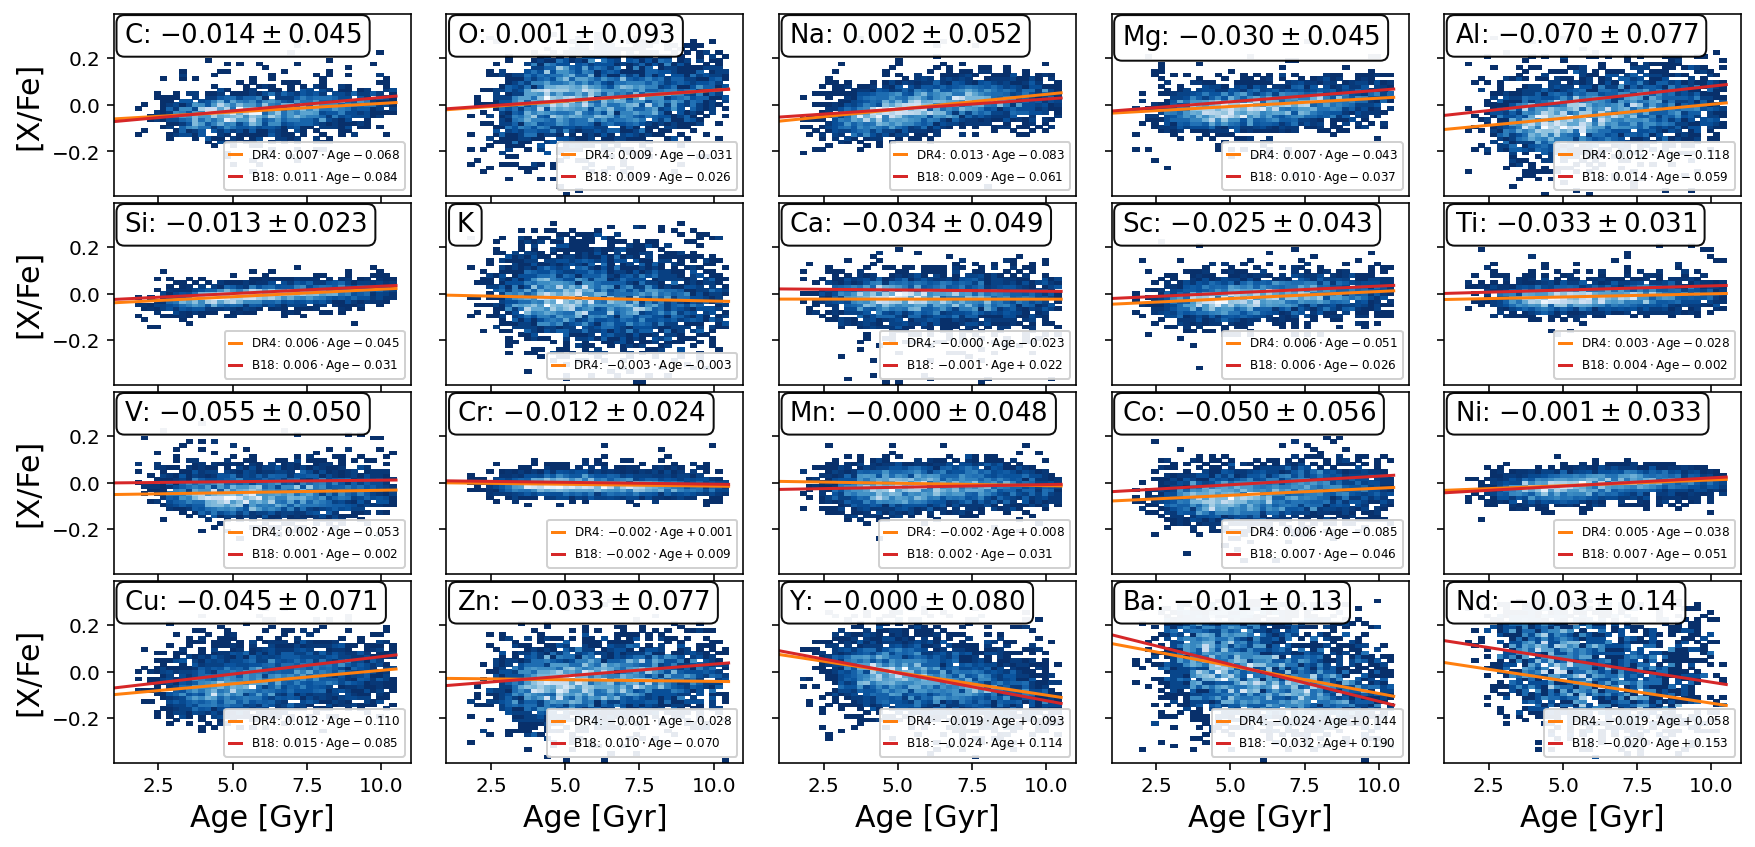

In [10]:

f, gs = plt.subplots(4,5,figsize=(12.5,6),sharex=True,sharey=True)

solar_twin_offsets = dict()

for each_index, each_element in enumerate(
    [
        'C','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr',
        'Mn','Co','Ni','Cu','Zn',
        'Y','Ba','Nd',
    ]
):
    
    row = int(np.floor(each_index/5))
    col = each_index - 5*row
    
    xfe_range=[-0.39,0.39]
    
    ax = gs[row,col]
    solar_twin_offsets[each_element] = plot_xfe_vs_age(ax=ax, each_element=each_element,xfe_range=xfe_range,age_bins = np.linspace(0.0,10.5,50))

    ax.set_xlim(1,11)
    if row == 3:
        ax.set_xlabel('Age [Gyr]',fontsize=15)
    if col == 0:
        ax.set_ylabel('[X/Fe]',fontsize=15)

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/galah_dr4_age_xfe_trends_solar_twins_'+setup+'.png',dpi=200,bbox_inches='tight')

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


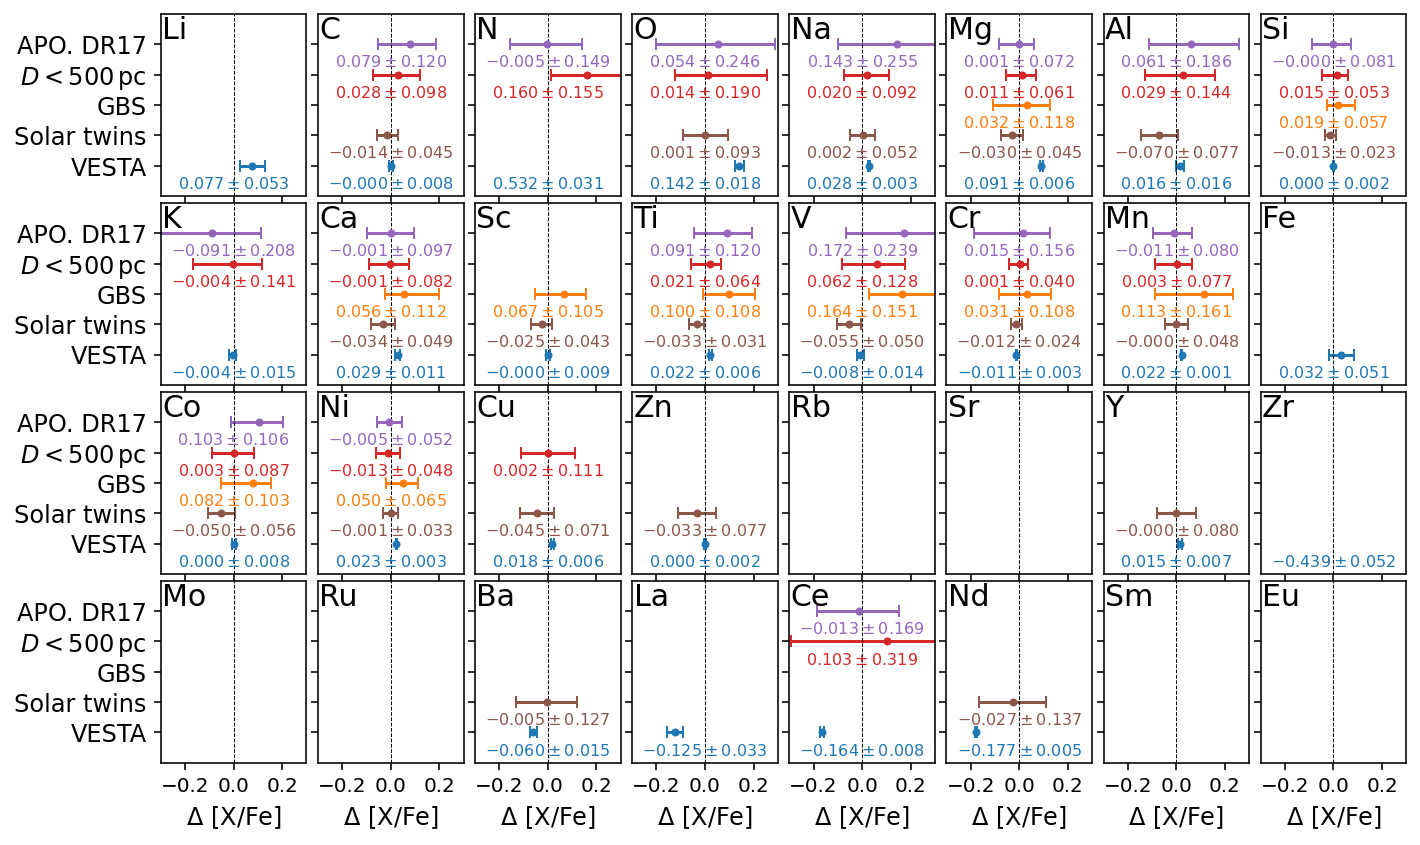

In [11]:
rows = 4
columns = 8

f, gs = plt.subplots(rows,columns,figsize=(10,6),sharex=True,sharey=True)

vesta = galah_dr4_raw[galah_dr4_raw['tmass_id'] == 'VESTA']

elements = [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu'
]

ff = "{:.3f}"

for index, element in enumerate(elements):
    
    row = int(np.floor(index/8))
    ax = gs[row,index-row*8]
    ax.text(0.01,0.99,element,transform=ax.transAxes,fontsize=15,ha='left',va='top')
    xlimits = [-0.3,0.3]
    ax.set_xlim(xlimits)
    
    if element == 'Fe':
        label = 'fe_h'
    else:
        label = element.lower()+'_fe'

    ax.errorbar(
        [vesta[label][0]],
        [0],
        xerr = vesta['e_'+label][0],
        capsize=3, c='C0', fmt='o', ms=3
    )
    if np.isfinite(vesta[label][0]):
        ax.text(0,-0.75,r'$'+ff.format(vesta[label][0])+'\pm'+ff.format(vesta['e_'+label][0])+'$',ha='center',fontsize=8,c='C0')
    
    if element in solar_twin_offsets.keys():
        std = 0.5*(solar_twin_offsets[element][2]-solar_twin_offsets[element][0])
        
        ax.errorbar(
            [solar_twin_offsets[element][1]],
            [1],
            xerr = std,
            capsize=3, c='C5', fmt='o', ms=3
        )
        if np.isfinite(solar_twin_offsets[element][1]):
            ax.text(0,0.25,r'$'+ff.format(solar_twin_offsets[element][1])+'\pm'+ff.format(std)+'$',ha='center',fontsize=8,c='C5')
    
    # Solar locus at [Fe/H] ~ 0
    use = (
        (np.abs(galah_dr4_raw['fe_h'] - 0.1) < 0.1) & 
        (galah_dr4_raw['flag_'+label] == 0) & 
        (galah_dr4_raw['r_med'] < 500)
    )
    
    # GBS
    if element in ['Mg','Si','Ca','Ti','Sc','V','Cr','Mn','Co','Ni']:
        
        gbs = comparison[element+'_fe'] - comparison[element+'_fe_gbs']
        perc = np.nanpercentile(gbs,q=[16,50,84])
        ax.errorbar(
            [perc[1]],
            [2],
            xerr = [[perc[2]-perc[1]],[perc[1]-perc[0]]],
            capsize=3, c='C1', fmt='o', ms=3
        )
        ax.text(0,1.25,r'$'+ff.format(perc[1])+'\pm'+ff.format(0.5*(perc[2]-perc[0]))+'$',ha='center',fontsize=8,c='C1')

    # Solar Circle

    if element in ['C','N','O','Na','Mg','Al','Si','K','Ca','Ti','V','Cr','Mn','Co','Ni','Cu','Ce']:
        
        use = (galah_dr4_raw['flag_'+element.lower()+'_fe']==0) & (galah_dr4_raw['r_med'] < 500) &  (np.abs(galah_dr4_raw['fe_h']) < 0.1)
        if len(galah_dr4_raw[element.lower()+'_fe'][use]) > 10:
            perc = np.nanpercentile(galah_dr4_raw[element.lower()+'_fe'][use],q=[16,50,84])
            ax.errorbar(
                [perc[1]],
                [3],
                xerr = [[perc[2]-perc[1]],[perc[1]-perc[0]]],
                capsize=3, c='C3', fmt='o', ms=3
            )
            ax.text(0,2.25,r'$'+ff.format(perc[1])+'\pm'+ff.format(0.5*(perc[2]-perc[0]))+'$',fontsize=8,c='C3',ha='center')

    # APOGEE DR17

    if element in ['C','N','O','Na','Mg','Al','Si','K','Ca','Ti','V','Cr','Mn','Co','Ni','Cu','Ce']:
        
        use = (
            (galah_dr4_apogee_dr17['flag_sp']==0) & 
            (galah_dr4_apogee_dr17['ASPCAPFLAG'] < 25231360) &
            (galah_dr4_apogee_dr17['flag_'+element.lower()+'_fe']==0) & 
            (galah_dr4_apogee_dr17[element.upper()+'_FE_FLAG']==0)
        )
        if len(galah_dr4_apogee_dr17[element.lower()+'_fe'][use]) > 10:
            apo = galah_dr4_apogee_dr17[element.lower()+'_fe'][use] - galah_dr4_apogee_dr17[element.upper()+'_FE'][use]
            perc = np.nanpercentile(apo,q=[16,50,84])
            ax.errorbar(
                [perc[1]],
                [4],
                xerr = [[perc[2]-perc[1]],[perc[1]-perc[0]]],
                capsize=3, c='C4', fmt='o', ms=3
            )
            ax.text(0,3.25,r'$'+ff.format(perc[1])+'\pm'+ff.format(0.5*(perc[2]-perc[0]))+'$',fontsize=8,c='C4',ha='center')

    ax.axvline(0,lw=0.5,ls='dashed',c='k')
    ax.set_yticks([0,1,2,3,4])
#     ax.set_yticklabels([r'$\odot$','G',r'$R_\odot$','A'])
    ax.set_yticklabels([r'VESTA','Solar twins','GBS',r'$D < 500\,\mathrm{pc}$','APO. DR17'],fontsize=12)
    ax.set_ylim(-1,5)
    ax.set_xticks([-0.2,0.0,0.2])
    if row+1 == rows:
        ax.set_xlabel(r'$\Delta~\mathrm{[X/Fe]}$',fontsize=12)

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/galah_dr4_zeropoint_checks_'+setup+'.png',dpi=200,bbox_inches='tight')

# 2) Precision

# Repeat observations

In [12]:
galah_dr4_allspec = Table.read('../catalogs/galah_dr4_allspec_230206.fits')

# use only flag_sp 0 or flag_sp == 2048 to get down to the low SNR results
exclude_bad = (galah_dr4_allspec['flag_sp'] == 0) | (galah_dr4_allspec['flag_sp'] == 2048)
galah_dr4_allspec = galah_dr4_allspec[exclude_bad]

# 'emission': [1, 'Emission in Halpha/Hbeta detected'],
#  'ccd_missing': [2, 'Not all 4 CCDs available'],
#  'is_sb1': [4, 'Spectroscopic Binary SB1 (RV changes beyond 2sigma)'],
#  'is_sb2': [8, 'Spectroscopic Binary SB2 (Double line splitting)'],
#  'chi2_3sigma': [16, 'Chi2 unusually low/high by 3 sigma'],
#  'vsini_warn': [32, 'Broadening (vsini) warning'],
#  'vmic_warn': [64, 'Microturbulence (vmic) warning'],
#  'sb_triple_warn': [128, 'Double line splitting detected (SB2)'],
#  'teff_warn': [256, 'Temperature (teff) warning'],
#  'logg_warn': [512, 'Gravity (logg) warning'],
#  'fe_h_warn': [1024, '[Fe/H] (fe_h) warning'],
#  'snr_warn': [2048, 'Signal-to-noise indicates spectra not reliable'],
#  'not_converged': [4096, 'Not converged within 4 iterations'],
#  'no_model': [8192, 'Extrapolating spectrum model'],
#  'no_results': [16384, 'No spectroscopic analysis results available']

galah_dr4_allspec_left_right = join(galah_dr4_allspec,galah_dr4_allspec,keys='tmass_id')

# Exclude same entries
repeat = galah_dr4_allspec_left_right[(galah_dr4_allspec_left_right['sobject_id_1'] != galah_dr4_allspec_left_right['sobject_id_2'])]
repeat['vrad_1'] = repeat['rv_comp_1_1']
repeat['vrad_2'] = repeat['rv_comp_1_2']
repeat['e_vrad_1'] = repeat['e_rv_comp_1_1']
repeat['e_vrad_2'] = repeat['e_rv_comp_1_2']
repeat['a_li_1'] = repeat['li_fe_1'] + repeat['fe_h_1'] + 1.05
repeat['a_li_2'] = repeat['li_fe_2'] + repeat['fe_h_2'] + 1.05
repeat['e_a_li_1'] = repeat['e_li_fe_1']
repeat['e_a_li_2'] = repeat['e_li_fe_2']
repeat['snr_1'] = repeat['snr_px_ccd2_1']
repeat['snr_2'] = repeat['snr_px_ccd2_2']

In [13]:
ranges = dict()
ranges['teff'] = 200
ranges['logg'] = 0.5
ranges['logg_spec'] = 0.5
ranges['fe_h'] = 0.2
ranges['vmic'] = 0.2
ranges['vsini'] = 2
ranges['vrad'] = 2
ranges['a_li'] = 2

precision_labels = ['teff','logg','logg_spec','fe_h','vmic','vsini','vrad','a_li']
for element in [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu'
]:
    precision_labels.append(element.lower()+'_fe')
    ranges[element.lower()+'_fe'] = 0.2

In [14]:
repeat_data = Table()

for label in precision_labels:
    repeat_data[label+'_mean'] = np.mean([repeat[label+'_1'],repeat[label+'_2']],axis=0)
    repeat_data[label+'_sigma'] = np.abs(repeat[label+'_1']-repeat[label+'_2'])/np.sqrt(2)
    #repeat_data[label+'_sigma'] = np.std([repeat[label+'_1'],repeat[label+'_2']],axis=0)
    repeat_data[label+'_cov'] = np.mean([repeat['e_'+label+'_1'],repeat['e_'+label+'_2']],axis=0)
    if label == 'logg':
        repeat_data[label+'_spec_sigma'] = np.abs(repeat[label+'_spec_1']-repeat[label+'_spec_2'])/np.sqrt(2)
        #repeat_data[label+'_spec_sigma'] = np.std([repeat[label+'_spec_1'],repeat[label+'_spec_2']],axis=0)
        repeat_data[label+'_spec_cov'] = np.mean([repeat['e_'+label+'_spec_1'],repeat['e_'+label+'_spec_2']],axis=0)

repeat_data['snr_mean'] = np.mean([repeat['snr_1'],repeat['snr_2']],axis=0)
repeat_data['snr_sigma'] = np.std([repeat['snr_1'],repeat['snr_2']],axis=0)

In [15]:
snr_bins = np.linspace(10,150,15); snr_bin_size = (snr_bins[1]-snr_bins[0])
for label in ['teff','logg','fe_h','vmic','vsini','vrad']:
    in_bin_allstar = (
        (galah_dr4_raw['snr_px_ccd2'] > 50 - 0.5*snr_bin_size) &
        (galah_dr4_raw['snr_px_ccd2'] <= 50 + 0.5*snr_bin_size) &
        ((galah_dr4_raw['flag_sp'] == 0) | (galah_dr4_raw['flag_sp'] == 2048)) & 
        np.isfinite(galah_dr4_raw[label]) & 
        np.isfinite(galah_dr4_raw['e_'+label])
    )
    if len(galah_dr4_raw['e_'+label][in_bin_allstar]) > 10:
        perc = np.percentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=[16,50,84])
        if label == 'teff':
            fmt = "{:.1f}"
        elif label in ['fe_h','vmic','vrad']:
            fmt = "{:.3f}"
        else:
            fmt = '{:.2f}'
        print('$'+fmt.format(perc[1])+' \pm '+fmt.format(0.5*(perc[2]-perc[0]))+'$')

$23.2 \pm 4.9$
$0.024 \pm 0.004$
$0.056 \pm 0.031$
$0.54 \pm 0.24$
$0.169 \pm 0.019$


In [17]:
re_assess_precision = False
save_precision = False

if not re_assess_precision:
    print('We have already assessed the precision and upscaled the covariance precision to match the repeat scatter')
    print('Skipping this step')

else:

    correction_factor = Table()

    ratios = Table()

    snr_bins = np.linspace(10,150,15); snr_bin_size = (snr_bins[1]-snr_bins[0])
    # snr_bins = np.linspace(10,200,11); snr_bin_size = (snr_bins[1]-snr_bins[0])

    ratios['snr'] = np.array(snr_bins)

    for label in precision_labels:

        print(label)
        
        if (label=='logg') | ((label=='logg_spec') & (setup=='allstar')):
            print('Ratio for logg will not be calculated for allstar')

        else:
            repeat = []
            covar = []
            cov2rep = []

            for snr in snr_bins:

                # print(label,teff,logg,fe_h,snr)

                in_bin_repeat = (
                    (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                    (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size) &
                    np.isfinite(repeat_data[label+'_sigma'])
                )

                if label[-3:] == '_fe':
                    in_bin_allstar = (
                            (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                            (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) &
                            ((galah_dr4_raw['flag_sp'] == 0) | (galah_dr4_raw['flag_sp'] == 2048)) & 
                            (galah_dr4_raw['flag_'+label] == 0) & 
                            np.isfinite(galah_dr4_raw[label]) & 
                            np.isfinite(galah_dr4_raw['e_'+label])
                        )
                else:
                    in_bin_allstar = (
                        (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                        (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) &
                        ((galah_dr4_raw['flag_sp'] == 0) | (galah_dr4_raw['flag_sp'] == 2048)) & 
                        np.isfinite(galah_dr4_raw[label]) & 
                        np.isfinite(galah_dr4_raw['e_'+label])
                    )

                if len(repeat_data[label+'_sigma'][in_bin_repeat]) > 50:
                    repeat.append(np.percentile(repeat_data[label+'_sigma'][in_bin_repeat],q=[16,50,84]))
                    if len(galah_dr4_raw['e_'+label][in_bin_allstar]) > 50:
                        covar.append(np.percentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=[16,50,84]))
                        cov2rep.append(
                            np.median(repeat_data[label+'_sigma'][in_bin_repeat])/
                            np.median(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2))
                        )
                    else:
                        covar.append([np.nan,np.nan,np.nan])
                        cov2rep.append(np.nan)
                else:
                    repeat.append([np.nan,np.nan,np.nan])
                    if len(galah_dr4_raw['e_'+label][in_bin_allstar]) > 50:
                        covar.append(np.percentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=[16,50,84]))
                        cov2rep.append(np.nan)
                    else:
                        covar.append([np.nan,np.nan,np.nan])
                        cov2rep.append(np.nan)

            ratios['repeats_'+label] = np.array(repeat,dtype=np.float32)
            ratios['covaris_'+label] = np.array(covar,dtype=np.float32)
            ratios['cov2rep_'+label] = np.array(cov2rep,dtype=np.float32)
            
            f, gs = plt.subplots(1,3,figsize=(10,3))
            ax = gs[0]
            ax.scatter(
                ratios['snr'],
                ratios['cov2rep_'+label]
            )

            ax = gs[1]
            ax.plot(
                ratios['snr'],
                ratios['repeats_'+label][:,1]
            )
            ax.fill_between(
                ratios['snr'],
                ratios['repeats_'+label][:,0],
                ratios['repeats_'+label][:,2],
                alpha=0.2
            )
            ax.plot(
                ratios['snr'],
                ratios['covaris_'+label][:,1]
            )
            ax.fill_between(
                ratios['snr'],
                ratios['covaris_'+label][:,0],
                ratios['covaris_'+label][:,2],
                alpha=0.2
            )

            ax = gs[2]
            ax.plot(
                ratios['snr'],
                ratios['repeats_'+label][:,1]
            )
            ax.fill_between(
                ratios['snr'],
                ratios['repeats_'+label][:,0],
                ratios['repeats_'+label][:,2],
                alpha=0.1
            )

            def bias_function(snr, c1):
                return((c1 * np.ones(len(snr))).clip(min=1))
            def lin_function(snr, c1, c2):
                return((c1 + c2 * snr).clip(min=1))
            def exp_function(snr, c1, c2, c3):
                return((c1 + c2 * np.exp(c3*snr)).clip(min=1))
            def lin_exp_function(snr, c1, c2, c3, c4):
                return((c1 + c2 * snr + c3 * np.exp(c4*snr)).clip(min=1))

            use_for_fit = (ratios['snr'] >= 20) & (ratios['snr'] <= 120) & np.isfinite(ratios['cov2rep_'+label])
            
            if (label == 'vrad') | ((label == 'logg') & (setup == 'allspec')):
                function = exp_function
                starting_values = [0,1,0]
                opt_parms, parm_cov = scipy.optimize.curve_fit(function,ratios['snr'][use_for_fit],ratios['cov2rep_'+label][use_for_fit],p0=starting_values)
                correction_factor[label] = [opt_parms[0],0,opt_parms[1],opt_parms[2]]
                
            else:
                function = lin_function
                starting_values = [3,0]
                
                opt_parms, parm_cov = scipy.optimize.curve_fit(function,ratios['snr'][use_for_fit],ratios['cov2rep_'+label][use_for_fit],p0=starting_values)
                correction_factor[label] = np.array([opt_parms[0],opt_parms[1],0,0],dtype=np.float32)

            function = lin_exp_function

            ax = gs[0]
            ax.plot(
                ratios['snr'][use_for_fit],
                function(ratios['snr'][use_for_fit],*correction_factor[label]),
                c = 'C1'
            )

            ax = gs[2]
            ax.plot(
                ratios['snr'],
                ratios['covaris_'+label][:,1]*function(ratios['snr'],*correction_factor[label])
            )
            ax.fill_between(
                ratios['snr'],
                ratios['covaris_'+label][:,0]*function(ratios['snr'],*correction_factor[label]),
                ratios['covaris_'+label][:,2]*function(ratios['snr'],*correction_factor[label]),
                alpha=0.1
            )

            plt.show()
            plt.close()

    if save_precision:
        correction_factor.write('../catalogs/galah_dr4_'+setup+'_precision_correction_factors.fits',overwrite=True)

We have already assessed the precision and upscaled the covariance precision to match the repeat scatter
Skipping this step


In [18]:
# ratios = Table()

# # We calculate up to 625 points in 4 dimensions (TEFF/LOGG/FE_H/SNR) to compare the ratio of Repeat2Covariance

# snr_bins = np.linspace(20,100,5); snr_bin_size = (snr_bins[1]-snr_bins[0])
# teff_bins = np.linspace(3500,7500,5); teff_bin_size = (teff_bins[1]-teff_bins[0])
# logg_bins = np.linspace(0.5,4.5,5); logg_bin_size = (logg_bins[1]-logg_bins[0])
# fe_h_bins = np.linspace(-2.5,0.5,5); fe_h_bin_size = (fe_h_bins[1]-fe_h_bins[0])

# print('Bins for SNR/TEFF/LOGG/FE_H: ',len(snr_bins),len(teff_bins),len(logg_bins),len(fe_h_bins))

# teffs = []
# loggs = []
# fe_hs = []
# snrs  = []

# for teff in teff_bins:
#     for logg in logg_bins:
#         for fe_h in fe_h_bins:
#             for snr in snr_bins:

#                 teffs.append(teff)
#                 loggs.append(logg)
#                 fe_hs.append(fe_h)
#                 snrs.append(snr)
                
# ratios['teff'] = np.array(teffs)
# ratios['logg'] = np.array(loggs)
# ratios['fe_h'] = np.array(fe_hs)
# ratios['snr'] = np.array(snrs)


# for label in precision_labels[:1]:
    
#     print(label)
    
#     if (label!='logg') | (setup!='allstar'):

#         repeat = []
#         covar = []
#         rep2cov = []

#         for teff_index,teff in enumerate(teff_bins):
#             if teff_index > 0:
#                 print('    done with '+str(100*teff_index/(len(teff_bins)-1))+'%')
#             for logg in logg_bins:
#                 for fe_h in fe_h_bins:
#                     for snr in snr_bins:

#                         # print(label,teff,logg,fe_h,snr)

#                         in_bin_repeat = (
#                             (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
#                             (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size) &
#                             (repeat_data['teff_mean'] > teff - 0.5*teff_bin_size) &
#                             (repeat_data['teff_mean'] <= teff + 0.5*teff_bin_size) &
#                             (repeat_data['logg_mean'] > logg - 0.5*logg_bin_size) &
#                             (repeat_data['logg_mean'] <= logg + 0.5*logg_bin_size) &
#                             (repeat_data['fe_h_mean'] > fe_h - 0.5*fe_h_bin_size) &
#                             (repeat_data['fe_h_mean'] <= fe_h + 0.5*fe_h_bin_size) &
#                             np.isfinite(repeat_data[label+'_sigma'])
#                         )

#                         if label[-3:] == '_fe':
#                             in_bin_allstar = (
#                                     (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
#                                     (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) &
#                                     (galah_dr4_raw['teff'] > teff - 0.5*teff_bin_size) &
#                                     (galah_dr4_raw['teff'] <= teff + 0.5*teff_bin_size) & 
#                                     (galah_dr4_raw['logg'] > logg - 0.5*logg_bin_size) &
#                                     (galah_dr4_raw['logg'] <= logg + 0.5*logg_bin_size) & 
#                                     (galah_dr4_raw['fe_h'] > fe_h - 0.5*fe_h_bin_size) &
#                                     (galah_dr4_raw['fe_h'] <= fe_h + 0.5*fe_h_bin_size) & 
#                                     ((galah_dr4_raw['flag_sp'] == 0) | (galah_dr4_raw['flag_sp'] == 2048)) & 
#                                     (galah_dr4_raw['flag_'+label] == 0)
#                                 )
#                         else:
#                             in_bin_allstar = (
#                                 (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
#                                 (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) &
#                                 (galah_dr4_raw['teff'] > teff - 0.5*teff_bin_size) &
#                                 (galah_dr4_raw['teff'] <= teff + 0.5*teff_bin_size) & 
#                                 (galah_dr4_raw['logg'] > logg - 0.5*logg_bin_size) &
#                                 (galah_dr4_raw['logg'] <= logg + 0.5*logg_bin_size) & 
#                                 (galah_dr4_raw['fe_h'] > fe_h - 0.5*fe_h_bin_size) &
#                                 (galah_dr4_raw['fe_h'] <= fe_h + 0.5*fe_h_bin_size) & 
#                                 ((galah_dr4_raw['flag_sp'] == 0) | (galah_dr4_raw['flag_sp'] == 2048)) & 
#                                 np.isfinite(galah_dr4_raw[label])
#                             )

#                         if len(repeat_data[label+'_sigma'][in_bin_repeat]) > 10:
#                             repeat.append(np.median(repeat_data[label+'_sigma'][in_bin_repeat]))
#                             if len(galah_dr4_raw['e_'+label][in_bin_allstar]) > 10:
#                                 covar.append(np.median(galah_dr4_raw['e_'+label][in_bin_allstar]))
#                                 rep2cov.append(np.median(repeat_data[label+'_sigma'][in_bin_repeat])/np.median(galah_dr4_raw['e_'+label][in_bin_allstar]))
#                             else:
#                                 covar.append(np.nan)
#                                 rep2cov.append(np.nan)
#                         else:
#                             repeat.append(np.nan)
#                             if len(galah_dr4_raw['e_'+label][in_bin_allstar]) > 10:
#                                 covar.append(np.median(galah_dr4_raw['e_'+label][in_bin_allstar]))
#                                 rep2cov.append(np.nan)
#                             else:
#                                 covar.append(np.nan)
#                                 rep2cov.append(np.nan)

#         ratios['repeats_'+label] = np.array(repeat,dtype=np.float32)
#         ratios['covaris_'+label] = np.array(covar,dtype=np.float32)
#         ratios['rep2cov_'+label] = np.array(rep2cov,dtype=np.float32)

#     else:
#         print('Ratio for logg will not be calculated for allstar')

# ratios.write('galah_dr4_repeats_and_covariances_'+setup+'.fits',overwrite=True)
# ratios

In [19]:
# f, gs = plt.subplots(5,5,figsize=(10,10),sharex=True,sharey=True)

# for fe_h_index, fe_h in enumerate(fe_h_bins):
#     for snr_index, snr in enumerate(snr_bins):

#         ax = gs[snr_index,fe_h_index]
#         ax.text(0.5,0.95,'SNR '+str(int(snr))+'\n[Fe/H] '+str(fe_h),ha='center',va='top',transform=ax.transAxes)

#         indices = []

#         for teff_index,teff in enumerate(teff_bins):
#             for logg_index, logg in enumerate(logg_bins):
#                 indices.append(
#                     np.where(
#                         (ratios['teff'] == teff) & 
#                         (ratios['logg'] == logg) & 
#                         (ratios['fe_h'] == fe_h) & 
#                         (ratios['snr'] == snr) 
#                     )[0][0]
#                 )
#         indices = np.array(indices)
        
#         s = ax.scatter(
#             ratios['teff'][indices],
#             ratios['logg'][indices],
#             c = np.log10(ratios['repeats_teff'][indices]),
#             s = 50,
#             cmap = 'plasma',
#             vmin = 1, vmax = 2
#         )
#         cbar = plt.colorbar(s,ax=ax,extend='both')
#         cbar.set_ticks([np.log10(10),np.log10(25),np.log10(50),np.log10(100)])
#         cbar.set_ticklabels([10,25,50,100])

# ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_ylim(ax.get_ylim()[::-1])


# plt.tight_layout(h_pad=0,w_pad=0)

In [20]:
# label = 'teff'

# s = plt.scatter(
#     ratios['teff'] - 5 * ratios['snr'],
#     ratios['logg'] - 0.1 * ratios['fe_h'],
#     c = 1.0/np.nanmedian(ratios['rep2cov_'+label]) * ratios['rep2cov_'+label],cmap = 'plasma',
#     vmin = 0.5,vmax = 1.5
# )
# s2 = plt.scatter(
#     7500. - 5 * snr_bins,
#     0.5 * np.ones(len(snr_bins)),
#     c = snr_bins, cmap = 'Reds'
# )
# s3 = plt.scatter(
#     7500. - np.zeros(len(snr_bins)),
#     0.5 - 0.1 * fe_h_bins,
#     c = fe_h_bins, cmap = 'Blues'
# )
# plt.xlim(8100,2900)
# plt.ylim(5,0)
# cbar1 = plt.colorbar(s)
# cbar2 = plt.colorbar(s2)
# cbar3 = plt.colorbar(s3)
# cbar1.set_label('Rep2Cov')
# cbar2.set_label('SNR')
# cbar3.set_label('[Fe/H]')
# plt.tight_layout()

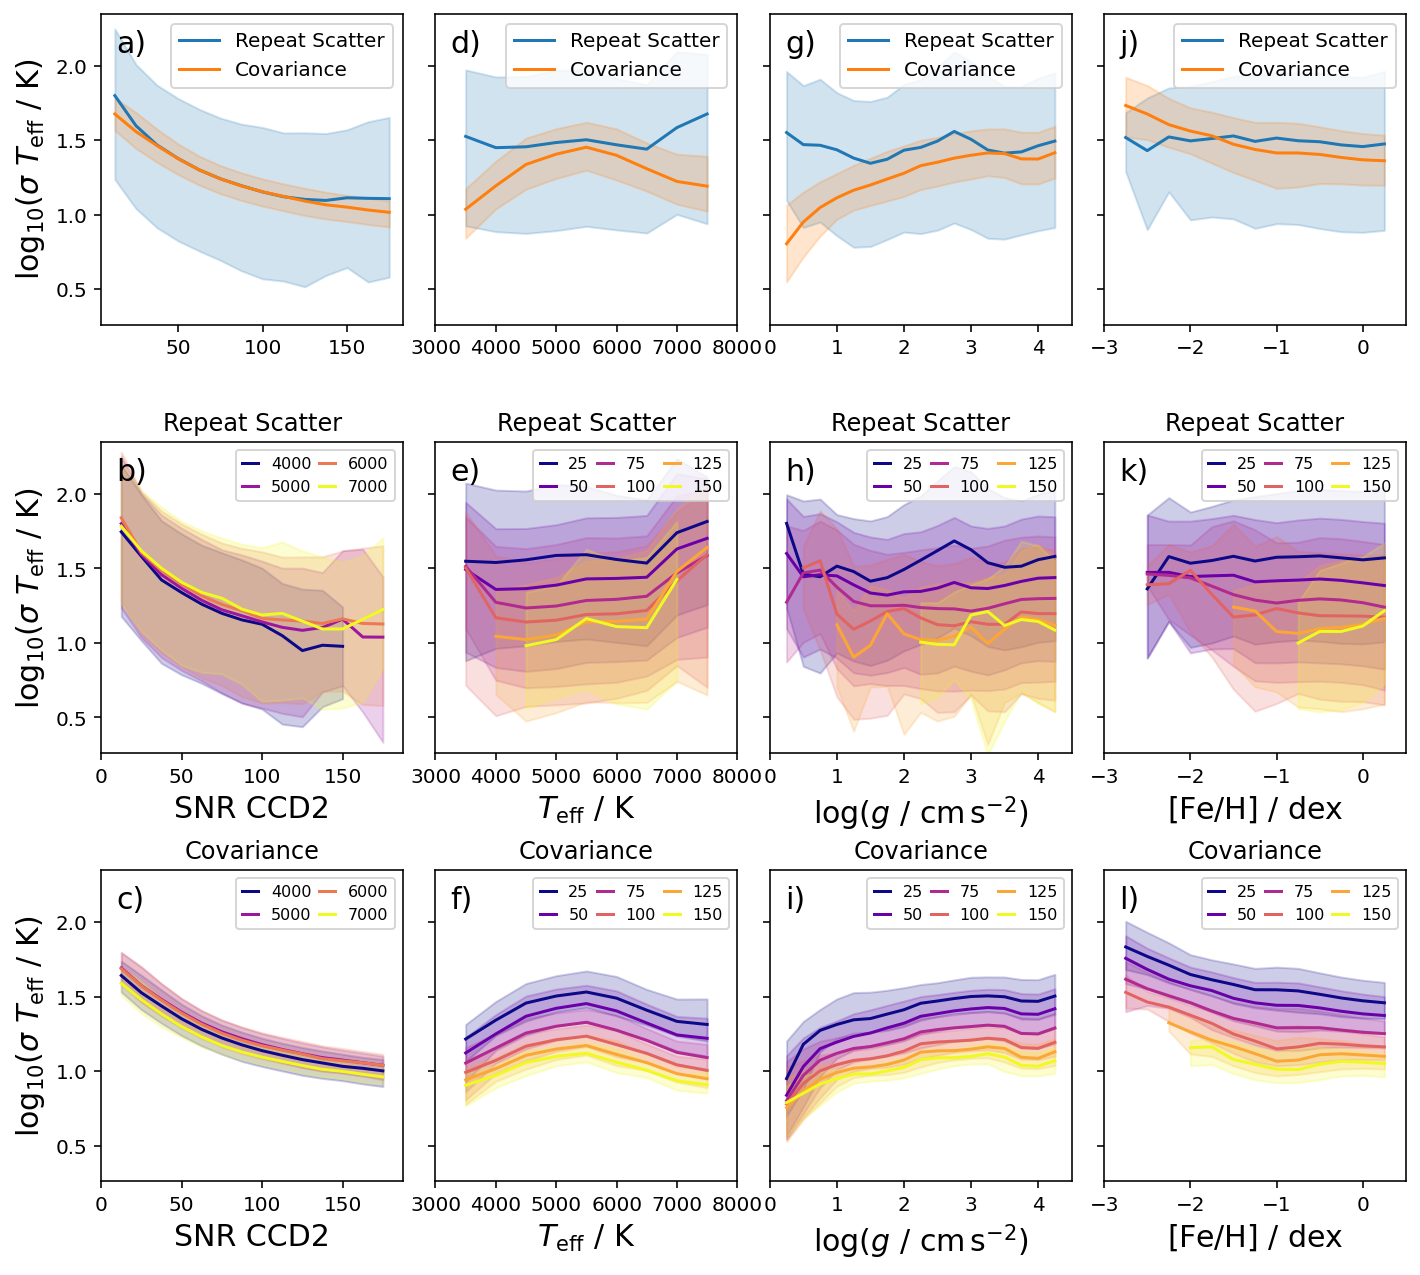

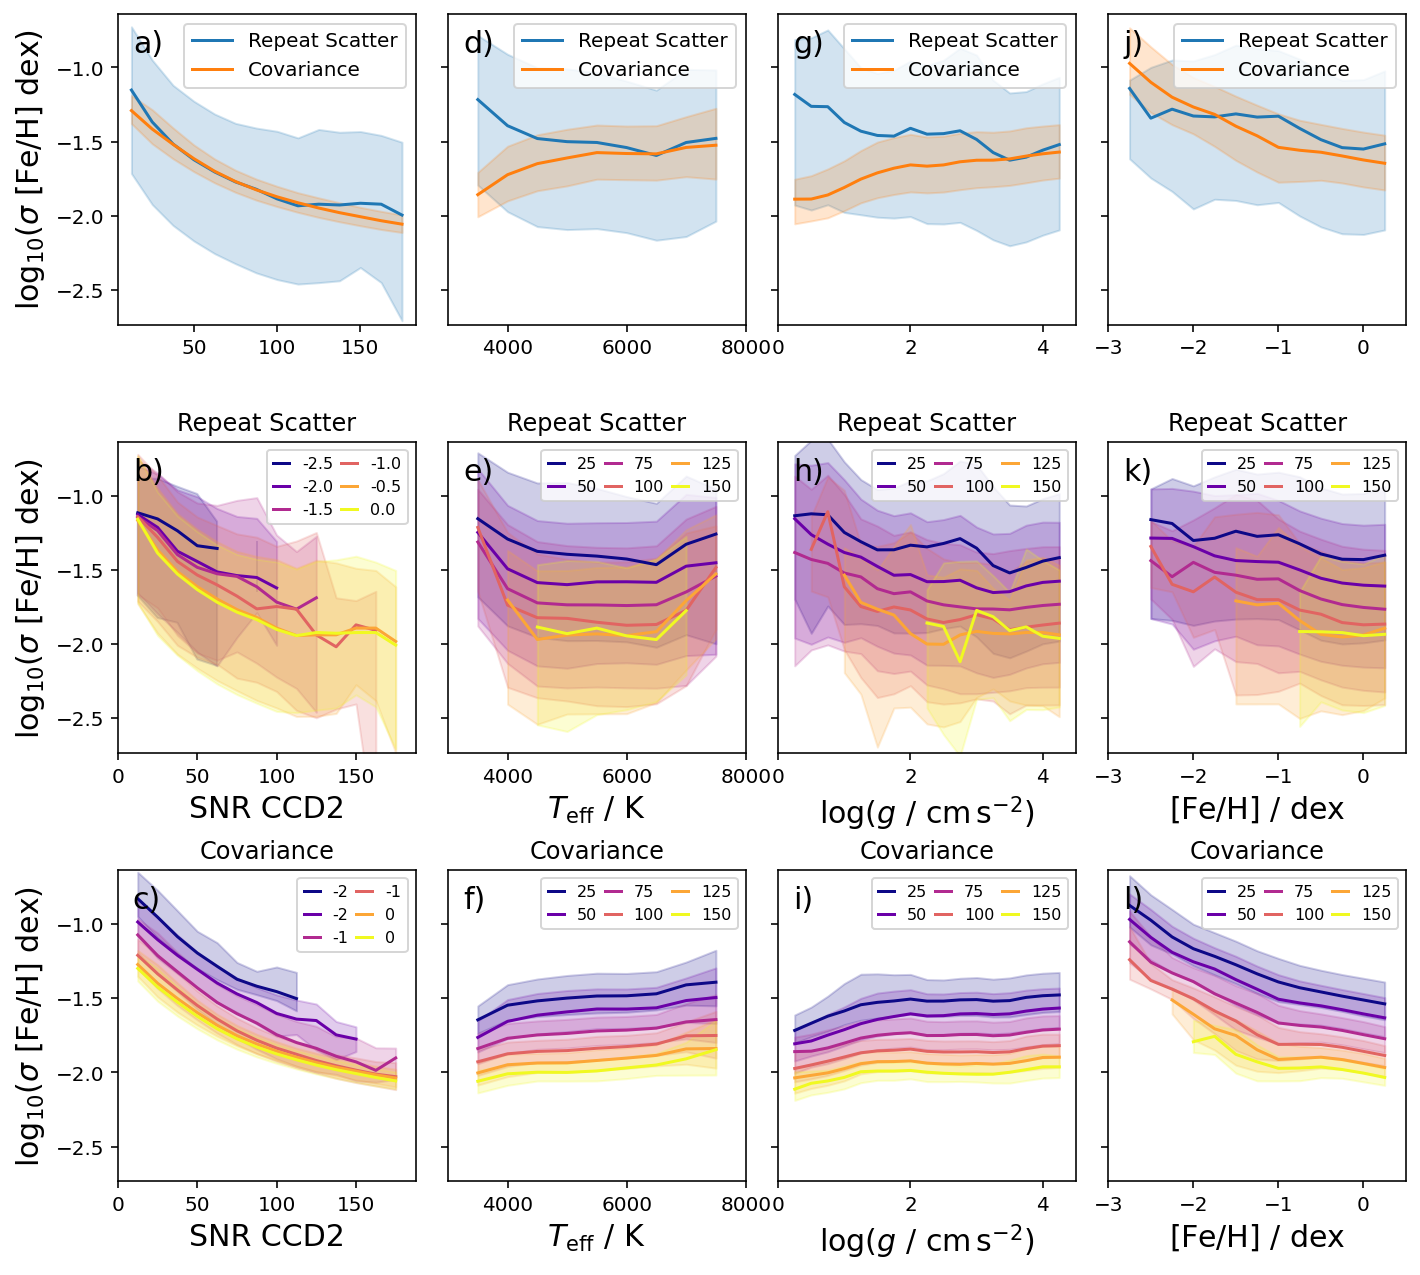

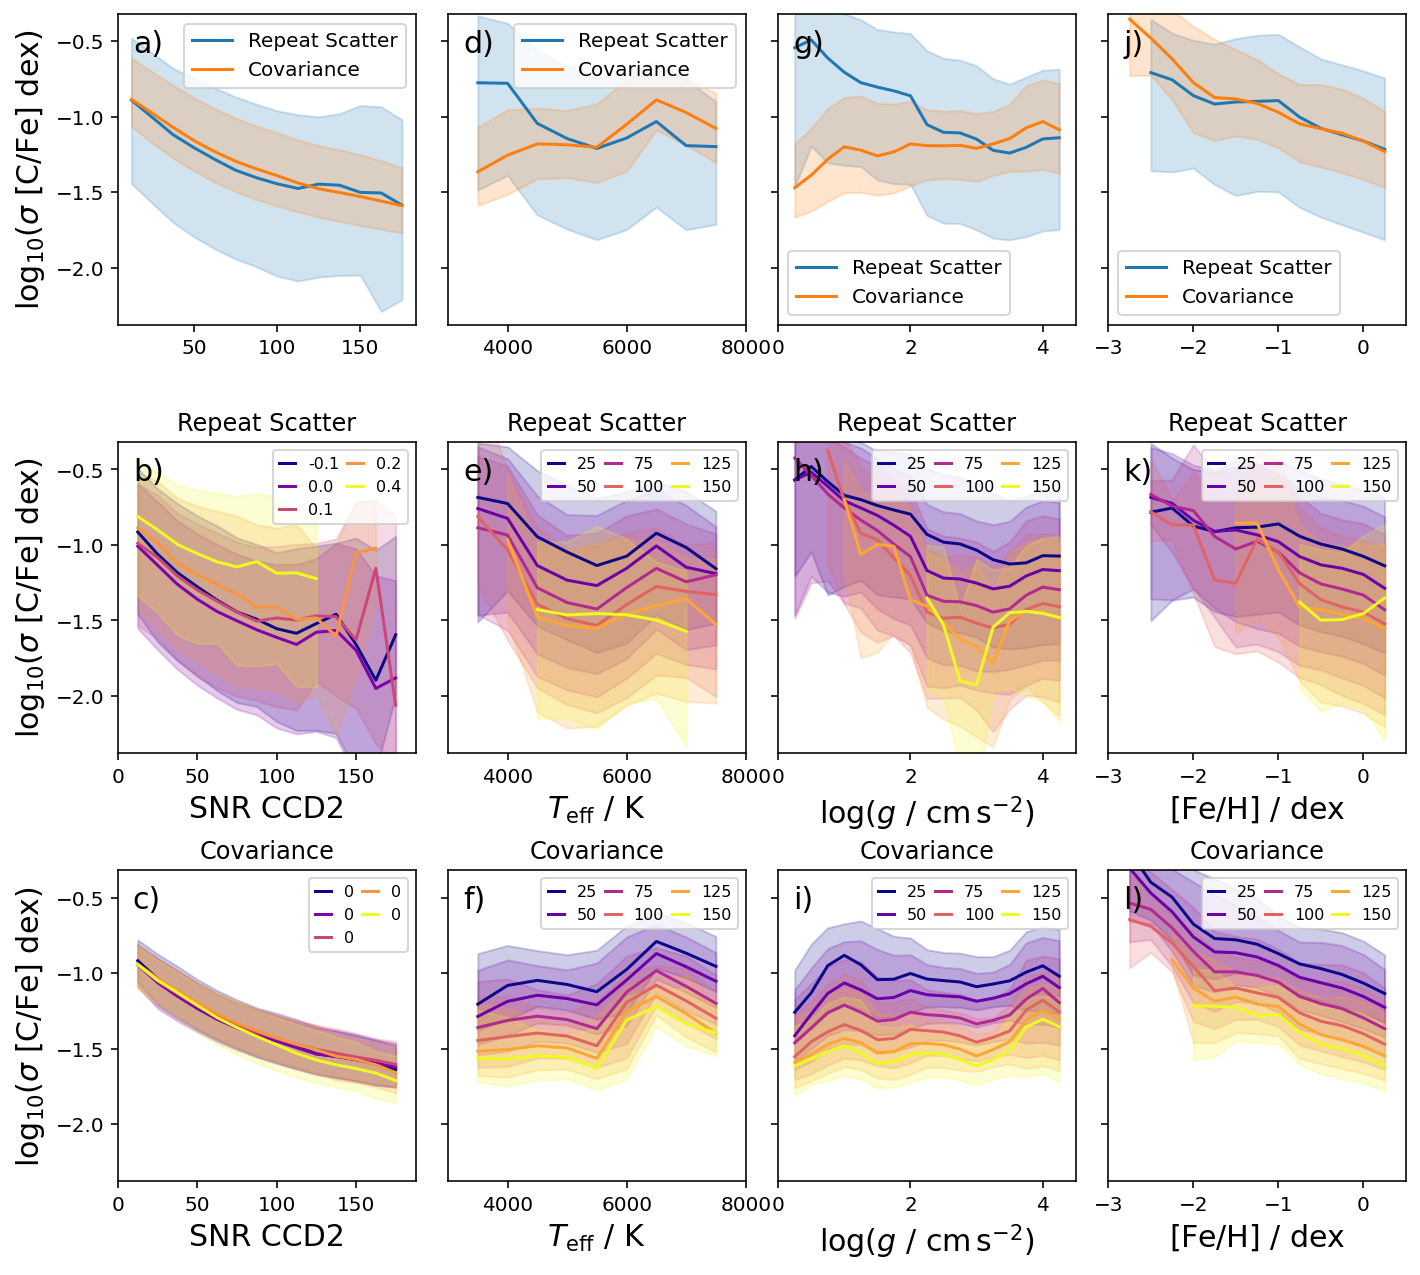

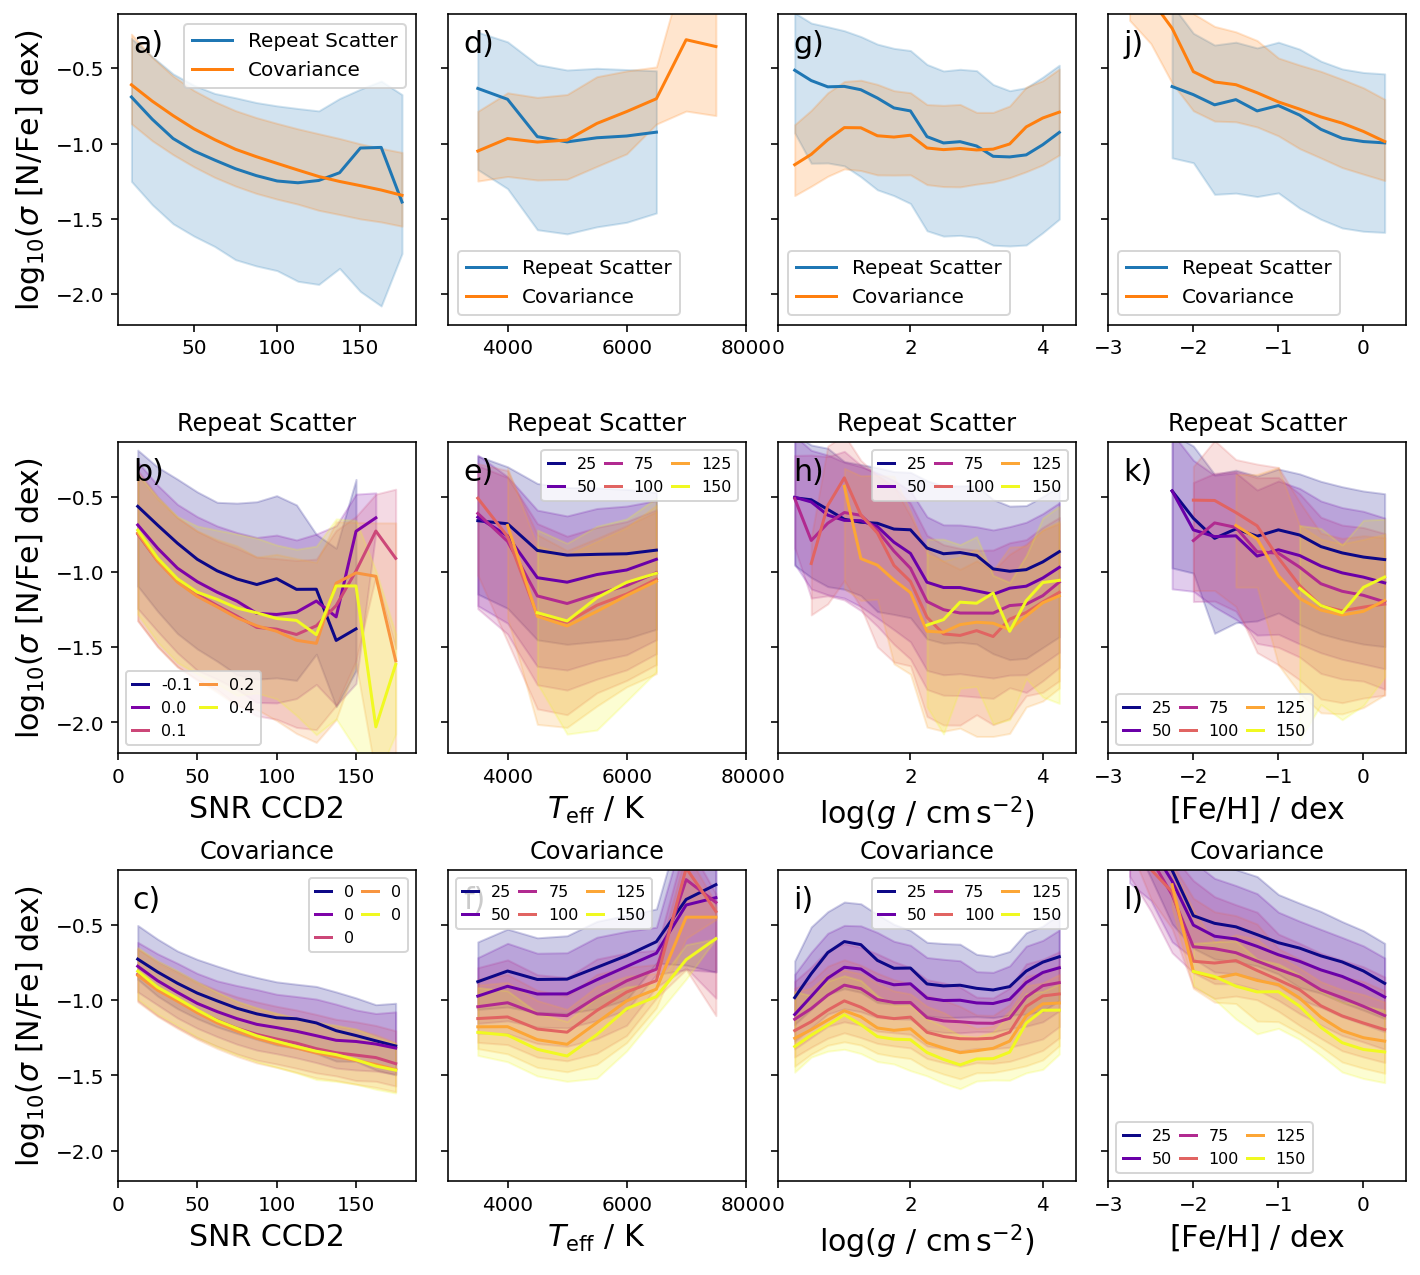

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice e

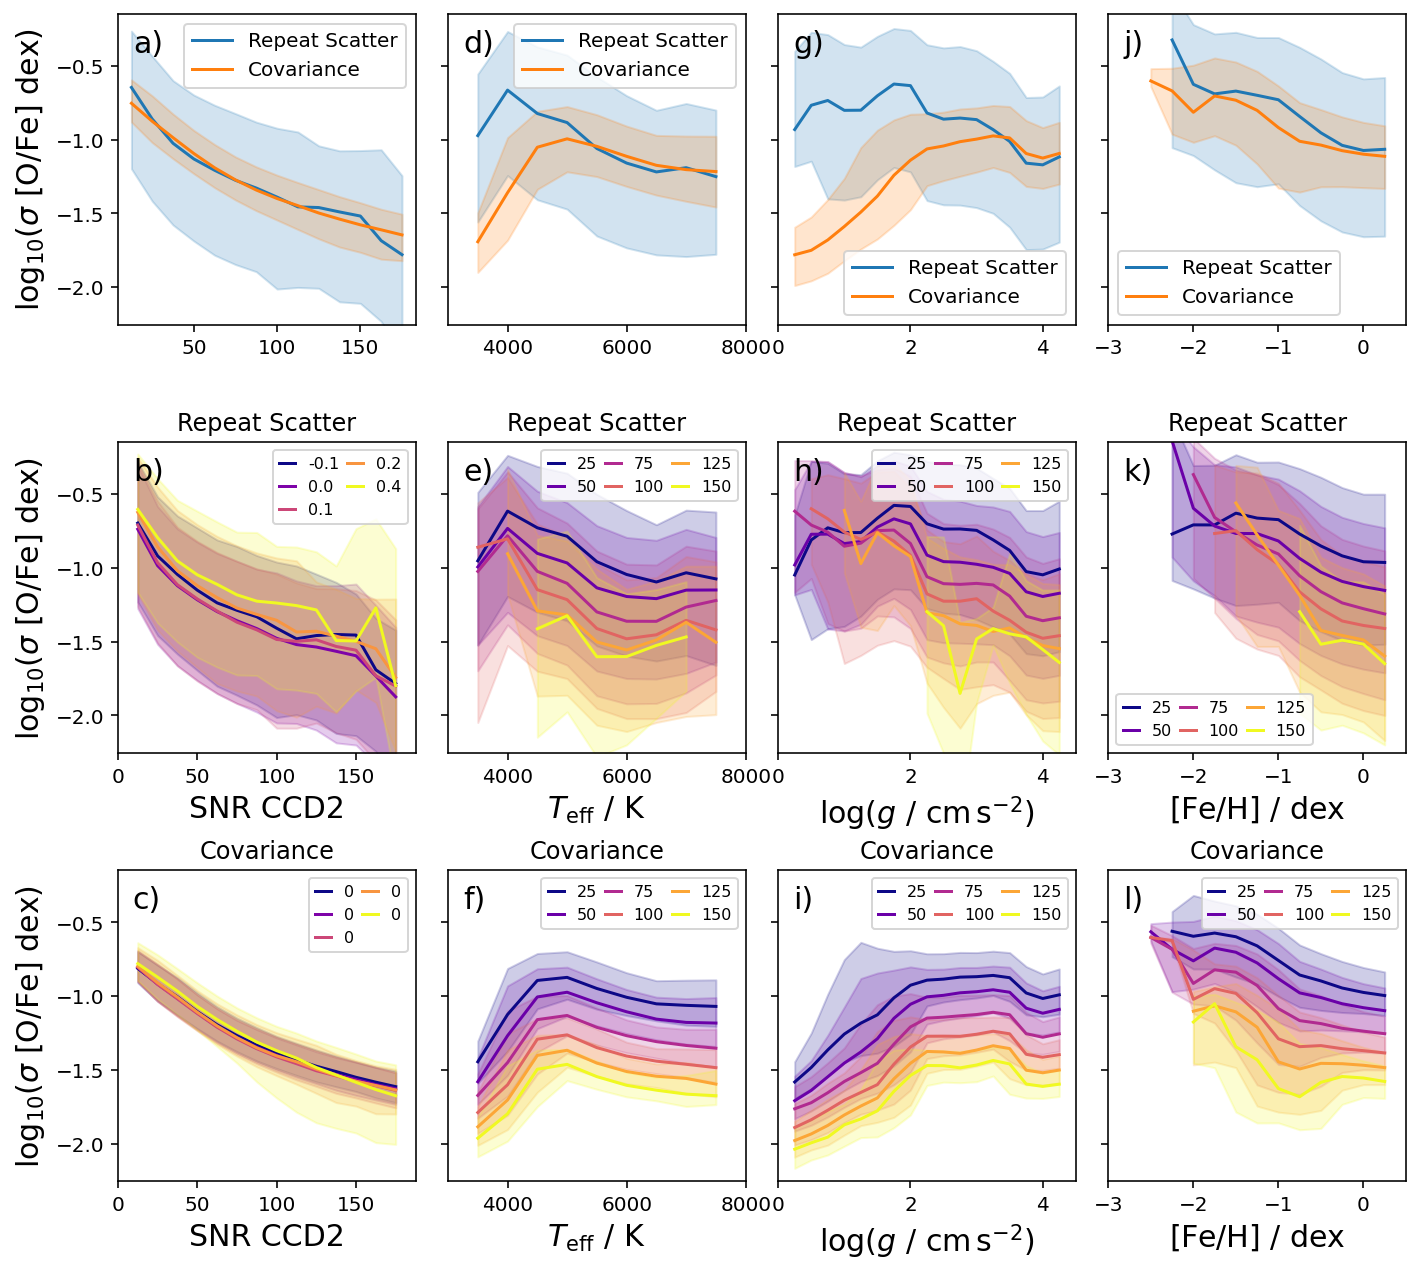

In [21]:
def plot_precision_diagnostics(label = 'teff', loglin = 'log10'):

    rows = 3
    cols = 4
    panels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']
    
    ylabels = dict()
    ylabels['teff'] = '\sigma~T_\mathrm{eff}~/~\mathrm{K}'
    ylabels['logg'] = '\sigma~\log (g~/~\mathrm{cm\,s^{-2}})'
    ylabels['fe_h'] = '\sigma~\mathrm{[Fe/H]}~\mathrm{dex}'
    ylabels['a_li'] = '\sigma~\mathrm{A(Li)}~\mathrm{dex}'
    if label not in ylabels.keys():
        if label[-3:] == '_fe':
            ylabels[label] = '\sigma~\mathrm{['+label[0].upper()+label[1:-3]+'/Fe]}~\mathrm{dex}'
        else:
            ylabels[label] = '\sigma~'+label
    
    f, gs = plt.subplots(rows,cols,figsize=(10,9),sharey=True)
    
    snr_bin_size  = 25
    snr_bins  = np.arange(snr_bin_size/2,175+snr_bin_size/2,snr_bin_size/2)

    percentiles = [16,50,84]

    cmap = matplotlib.cm.get_cmap('plasma')

    ##################################################
    index = 0
    ax = gs[index%rows,int(index/rows)]
    ax.text(0.05,0.95,panels[index],ha='left',va='top',transform=ax.transAxes,fontsize=15)
    if loglin == 'log10':
        ax.set_ylabel(r'$\log_{10} ('+ylabels[label]+'$)',fontsize=15)
    else:
        ax.set_ylabel(r'$'+ylabels[label]+'$',fontsize=15)
    
    percentiles_sigma = []
    percentiles_cov = []

    for snr in snr_bins:

        in_bin_repeat = (
            (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
            (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size) &
            np.isfinite(repeat_data[label+'_sigma'])
        )
        if len(repeat_data['snr_mean'][in_bin_repeat]) > 10:
            percentiles_sigma.append(np.nanpercentile(repeat_data[label+'_sigma'][in_bin_repeat],q=percentiles))
        else:
            percentiles_sigma.append([np.nan,np.nan,np.nan])

        in_bin_allstar = (
            (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
            (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) & 
            (galah_dr4_raw['flag_sp'] == 0)
        )
        if len(galah_dr4_raw[label][in_bin_allstar]) > 10:
            percentiles_cov.append(np.nanpercentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=percentiles))
        else:
            percentiles_cov.append([np.nan,np.nan,np.nan])

    percentiles_sigma = np.array(percentiles_sigma)
    percentiles_cov = np.array(percentiles_cov)

    if loglin == 'log10':
        percentiles_sigma = np.log10(percentiles_sigma)
        percentiles_cov = np.log10(percentiles_cov)
    
    ax.plot(
        snr_bins,
        percentiles_sigma[:,1],
        label = 'Repeat Scatter',
        c = 'C0'
    )
    ax.fill_between(
        snr_bins,
        percentiles_sigma[:,0],
        percentiles_sigma[:,2],
        alpha=0.2,
        color = 'C0',
        label = '_nolegend_'
    )
    ax.plot(
        snr_bins,
        percentiles_cov[:,1],
        label = 'Covariance',
        c = 'C1'
    )
    ax.fill_between(
        snr_bins,
        percentiles_cov[:,0],
        percentiles_cov[:,2],
        alpha=0.2,
        color = 'C1',
        label = '_nolegend_'
    )
    ax.legend()

    ##################################################
    index = 1
    ax = gs[index%rows,int(index/rows)]
    ax.text(0.05,0.95,panels[index],ha='left',va='top',transform=ax.transAxes,fontsize=15)
    ax.set_xlabel('SNR CCD2',fontsize=15)
    if loglin == 'log10':
        ax.set_ylabel(r'$\log_{10} ('+ylabels[label]+'$)',fontsize=15)
    else:
        ax.set_ylabel(r'$'+ylabels[label]+'$',fontsize=15)

    if label == 'teff':
        ref_bin_size = 2000
        ref_bins = np.arange(3000+ref_bin_size/2,8001-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.0f}"
    elif label == 'logg':
        ref_bin_size = 2
        ref_bins = np.arange(-0.5+ref_bin_size/2,5.01-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.1f}"
    elif label == 'fe_h':
        ref_bin_size = 1
        ref_bins = np.arange(-3.0+ref_bin_size/2,0.51-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.1f}"
    elif label == 'vmic':
        ref_bin_size = 2
        ref_bins = np.arange(0.0+ref_bin_size/2,4.01-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.1f}"
    elif label == 'vsini':
        ref_bin_size = 10
        ref_bins = np.arange(0.0+ref_bin_size/2,20.1-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.1f}"
    elif label == 'a_li':
        ref_bin_size = 1
        ref_bins = np.arange(0.0+ref_bin_size/2,4.01-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.1f}"
    elif label[-3:] == '_fe':
        ref_bin_size = 0.25
        ref_bins = np.arange(-0.25+ref_bin_size/2,0.51-ref_bin_size/2,ref_bin_size/2)
        label_format = "{:.1f}"
    else:
        raise ValueError('No ref_bins defined')
    ax.set_xlim(snr_bins[0]-snr_bin_size/2,snr_bins[-1]+snr_bin_size/2)

    for ref_index, ref in enumerate(ref_bins):
    
        percentiles_sigma = []

        for snr_index, snr in enumerate(snr_bins):

            in_bin_repeat = (
                (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size) &
                (repeat_data[label+'_mean'] > ref - 0.5*ref_bin_size) &
                (repeat_data[label+'_mean'] <= ref + 0.5*ref_bin_size) &
                np.isfinite(repeat_data[label+'_sigma'])
            )
            if len(repeat_data['snr_mean'][in_bin_repeat]) > 10:
                percentiles_sigma.append(np.nanpercentile(repeat_data[label+'_sigma'][in_bin_repeat],q=percentiles))
            else:
                percentiles_sigma.append([np.nan,np.nan,np.nan])

        percentiles_sigma = np.array(percentiles_sigma)
        if loglin == 'log10':
            percentiles_sigma = np.log10(percentiles_sigma)

        ax.plot(
            snr_bins,
            percentiles_sigma[:,1],
            label = label_format.format(ref),
            color = cmap(ref_index/(len(ref_bins)-1)),
        )
        ax.fill_between(
            snr_bins,
            percentiles_sigma[:,0],
            percentiles_sigma[:,2],
            alpha=0.2,
            color = cmap(ref_index/(len(ref_bins)-1)),
            label = '_nolegend_'
        )
    ax.set_title('Repeat Scatter')
    ax.legend(ncol=2,fontsize=8,handlelength=1,columnspacing=0.5)

    
    ##################################################
    index = 2
    ax = gs[index%rows,int(index/rows)]
    ax.text(0.05,0.95,panels[index],ha='left',va='top',transform=ax.transAxes,fontsize=15)
    ax.set_xlabel('SNR CCD2',fontsize=15)
    if loglin == 'log10':
        ax.set_ylabel(r'$\log_{10} ('+ylabels[label]+'$)',fontsize=15)
    else:
        ax.set_ylabel(r'$'+ylabels[label]+'$',fontsize=15)
    ax.set_xlim(snr_bins[0]-snr_bin_size/2,snr_bins[-1]+snr_bin_size/2)
    ax.set_title('Covariance')

    if label != 'logg':

        for ref_index, ref in enumerate(ref_bins):

            percentiles_cov = []

            for snr_index, snr in enumerate(snr_bins):

                in_bin_allstar = (
                    (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                    (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) & 
                    (galah_dr4_raw[label] > ref - 0.5*ref_bin_size) &
                    (galah_dr4_raw[label] <= ref + 0.5*ref_bin_size) & 
                    (galah_dr4_raw['flag_sp'] == 0)
                )
                if label[-3:] == '_fe':
                    in_bin_allstar = (
                        (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                        (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) & 
                        (galah_dr4_raw[label] > ref - 0.5*ref_bin_size) &
                        (galah_dr4_raw[label] <= ref + 0.5*ref_bin_size) & 
                        (galah_dr4_raw['flag_sp'] == 0) & 
                        (galah_dr4_raw['flag_'+label] == 0)
                    )
                if len(galah_dr4_raw[label][in_bin_allstar]) > 10:
                    percentiles_cov.append(np.nanpercentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=percentiles))
                else:
                    percentiles_cov.append([np.nan,np.nan,np.nan])

            percentiles_cov = np.array(percentiles_cov)
            if loglin == 'log10':
                percentiles_cov = np.log10(percentiles_cov)

            ax.plot(
                snr_bins,
                percentiles_cov[:,1],
                label = str(int(ref)),
                color = cmap(ref_index/(len(ref_bins)-1)),
            )
            ax.fill_between(
                snr_bins,
                percentiles_cov[:,0],
                percentiles_cov[:,2],
                alpha=0.2,
                color = cmap(ref_index/(len(ref_bins)-1)),
                label = '_nolegend_'
            )
        ax.legend(ncol=2,fontsize=8,handlelength=1,columnspacing=0.5)

    ##################################################
    
    for ref_index, reference in enumerate(['teff','logg','fe_h']):

        ##################################################
        index = 3 + ref_index * 3
        ax = gs[index%rows,int(index/rows)]
        ax.text(0.05,0.95,panels[index],ha='left',va='top',transform=ax.transAxes,fontsize=15)

        snr_bin_size  = 50
        snr_bins  = np.arange(snr_bin_size/2,150+snr_bin_size/2,snr_bin_size/2)

        if reference == 'teff':
            ref_bin_size = 1000
            ref_bins = np.arange(3000+ref_bin_size/2,8001-ref_bin_size/2,ref_bin_size/2)
        if reference == 'logg':
            ref_bin_size = 0.5
            ref_bins = np.arange(0.0+ref_bin_size/2,4.51-ref_bin_size/2,ref_bin_size/2)
        if reference == 'fe_h':
            ref_bin_size = 0.5
            ref_bins = np.arange(-3.0+ref_bin_size/2,0.51-ref_bin_size/2,ref_bin_size/2)
        ax.set_xlim(ref_bins[0]-ref_bin_size/2,ref_bins[-1]+ref_bin_size/2)

        percentiles_sigma = []
        percentiles_cov = []

        for ref in ref_bins:

            in_bin_repeat = (
                (repeat_data[reference+'_mean'] > ref - 0.5*ref_bin_size) &
                (repeat_data[reference+'_mean'] <= ref + 0.5*ref_bin_size) &
                np.isfinite(repeat_data[label+'_sigma'])
            )
            if len(repeat_data['snr_mean'][in_bin_repeat]) > 10:
                percentiles_sigma.append(np.nanpercentile(repeat_data[label+'_sigma'][in_bin_repeat],q=percentiles))
            else:
                percentiles_sigma.append([np.nan,np.nan,np.nan])
                
            in_bin_allstar = (
                (galah_dr4_raw[reference] > ref - 0.5*ref_bin_size) &
                (galah_dr4_raw[reference] <= ref + 0.5*ref_bin_size) & 
                (galah_dr4_raw['flag_sp'] == 0)
            )
            
            if len(galah_dr4_raw[label][in_bin_allstar]) > 10:
                percentiles_cov.append(np.nanpercentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=percentiles))
            else:
                percentiles_cov.append([np.nan,np.nan,np.nan])

        percentiles_sigma = np.array(percentiles_sigma)
        percentiles_cov = np.array(percentiles_cov)
        if loglin == 'log10':
            percentiles_sigma = np.log10(percentiles_sigma)
            percentiles_cov = np.log10(percentiles_cov)

        ax.plot(
            ref_bins,
            percentiles_sigma[:,1],
            label = 'Repeat Scatter',
            c = 'C0'
        )
        ax.fill_between(
            ref_bins,
            percentiles_sigma[:,0],
            percentiles_sigma[:,2],
            alpha=0.2,
            color = 'C0',
            label = '_nolegend_'
        )
        ax.plot(
            ref_bins,
            percentiles_cov[:,1],
            label = 'Covariance',
            c = 'C1'
        )
        ax.fill_between(
            ref_bins,
            percentiles_cov[:,0],
            percentiles_cov[:,2],
            alpha=0.2,
            color = 'C1',
            label = '_nolegend_'
        )
        ax.legend()
        
        ##################################################
        index = 4 + ref_index * 3
        ax = gs[index%rows,int(index/rows)]
        ax.text(0.05,0.95,panels[index],ha='left',va='top',transform=ax.transAxes,fontsize=15)

        if reference == 'teff':
            ref_bin_size = 1000
            ref_bins = np.arange(3000+ref_bin_size/2,8001-ref_bin_size/2,ref_bin_size/2)
            ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
        if reference == 'logg':
            ref_bin_size = 0.5
            ref_bins = np.arange(0.0+ref_bin_size/2,4.51-ref_bin_size/2,ref_bin_size/2)
            ax.set_xlabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
        if reference == 'fe_h':
            ref_bin_size = 0.5
            ref_bins = np.arange(-3.0+ref_bin_size/2,0.51-ref_bin_size/2,ref_bin_size/2)
            ax.set_xlabel(r'$\mathrm{[Fe/H]}~/~\mathrm{dex}$',fontsize=15)
        ax.set_xlim(ref_bins[0]-ref_bin_size/2,ref_bins[-1]+ref_bin_size/2)

        for snr_index, snr in enumerate(snr_bins):

            percentiles_sigma = []

            for ref in ref_bins:
                
                in_bin_repeat = (
                    (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                    (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size) &
                    (repeat_data[reference+'_mean'] > ref - 0.5*ref_bin_size) &
                    (repeat_data[reference+'_mean'] <= ref + 0.5*ref_bin_size) &
                    np.isfinite(repeat_data[label+'_sigma'])
                )
                                
                if len(repeat_data['snr_mean'][in_bin_repeat]) > 10:
                    percentiles_sigma.append(np.nanpercentile(repeat_data[label+'_sigma'][in_bin_repeat],q=percentiles))
                else:
                    percentiles_sigma.append([np.nan,np.nan,np.nan])

            percentiles_sigma = np.array(percentiles_sigma)
            if loglin == 'log10':
                percentiles_sigma = np.log10(percentiles_sigma)

            ax.plot(
                ref_bins,
                percentiles_sigma[:,1],
                label = str(int(snr)),
                color = cmap(snr_index/(len(snr_bins)-1)),
            )
            ax.fill_between(
                ref_bins,
                percentiles_sigma[:,0],
                percentiles_sigma[:,2],
                alpha=0.2,
                color = cmap(snr_index/(len(snr_bins)-1)),
                label = '_nolegend_'
            )
        ax.set_title('Repeat Scatter')
        ax.legend(ncol=3,fontsize=8,handlelength=1,columnspacing=0.5)
        
        ##################################################
        index = 5 + ref_index * 3
        ax = gs[index%rows,int(index/rows)]
        ax.text(0.05,0.95,panels[index],ha='left',va='top',transform=ax.transAxes,fontsize=15)

        if reference == 'teff':
            ref_bin_size = 1000
            ref_bins = np.arange(3000+ref_bin_size/2,8001-ref_bin_size/2,ref_bin_size/2)
            ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
        if reference == 'logg':
            ref_bin_size = 0.5
            ref_bins = np.arange(0.0+ref_bin_size/2,4.51-ref_bin_size/2,ref_bin_size/2)
            ax.set_xlabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
        if reference == 'fe_h':
            ref_bin_size = 0.5
            ref_bins = np.arange(-3.0+ref_bin_size/2,0.51-ref_bin_size/2,ref_bin_size/2)
            ax.set_xlabel(r'$\mathrm{[Fe/H]}~/~\mathrm{dex}$',fontsize=15)
        ax.set_xlim(ref_bins[0]-ref_bin_size/2,ref_bins[-1]+ref_bin_size/2)
        ax.set_title('Covariance')

        if label != 'logg':

            for snr_index, snr in enumerate(snr_bins):

                percentiles_cov = []

                for ref in ref_bins:

                    in_bin_allstar = (
                        (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                        (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) &
                        (galah_dr4_raw[reference] > ref - 0.5*ref_bin_size) &
                        (galah_dr4_raw[reference] <= ref + 0.5*ref_bin_size) & 
                        (galah_dr4_raw['flag_sp'] == 0)
                    )
                    if len(galah_dr4_raw[label][in_bin_allstar]) > 10:
                        percentiles_cov.append(np.nanpercentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin_allstar]**2-accuracy_values[label]**2),q=percentiles))
                    else:
                        percentiles_cov.append([np.nan,np.nan,np.nan])

                percentiles_cov = np.array(percentiles_cov)
                if loglin == 'log10':
                    percentiles_cov = np.log10(percentiles_cov)

                ax.plot(
                    ref_bins,
                    percentiles_cov[:,1],
                    label = str(int(snr)),
                    color = cmap(snr_index/(len(snr_bins)-1)),
                )
                ax.fill_between(
                    ref_bins,
                    percentiles_cov[:,0],
                    percentiles_cov[:,2],
                    alpha=0.2,
                    color = cmap(snr_index/(len(snr_bins)-1)),
                    label = '_nolegend_'
                )
            ax.legend(ncol=3,fontsize=8,handlelength=1,columnspacing=0.5)
            
    ##################################################

    finite = np.isfinite(repeat_data[label+'_sigma'])
    if loglin == 'log10':
        ax.set_ylim(
            np.log10(0.75 * np.nanpercentile(repeat_data[label+'_sigma'][finite],q=5)),
            np.log10(1.25 * np.nanpercentile(repeat_data[label+'_sigma'][finite],q=95))
        )
    else:
        ax.set_ylim(
            0.75 * np.nanpercentile(repeat_data[label+'_sigma'][finite],q=5),
            1.25 * np.nanpercentile(repeat_data[label+'_sigma'][finite],q=95)
        )

    plt.tight_layout(w_pad=0,h_pad=0)
    plt.show()
    plt.close()

plot_precision_diagnostics(label = 'teff')
# plot_precision_diagnostics(label = 'logg')
plot_precision_diagnostics(label = 'fe_h')
# plot_precision_diagnostics(label = 'vmic')
# plot_precision_diagnostics(label = 'vsini')
# plot_precision_diagnostics(label = 'a_li',loglin='lin')
elements = [
        #'Li',
        'C','N','O',
#         'Na','Mg','Al','Si',
#         'K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
#         'Rb','Sr','Y','Zr','Mo','Ru',
#         'Ba','La','Ce','Nd','Sm','Eu'
]
for element in elements:
    plot_precision_diagnostics(label = element.lower()+'_fe')#,loglin='lin')

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


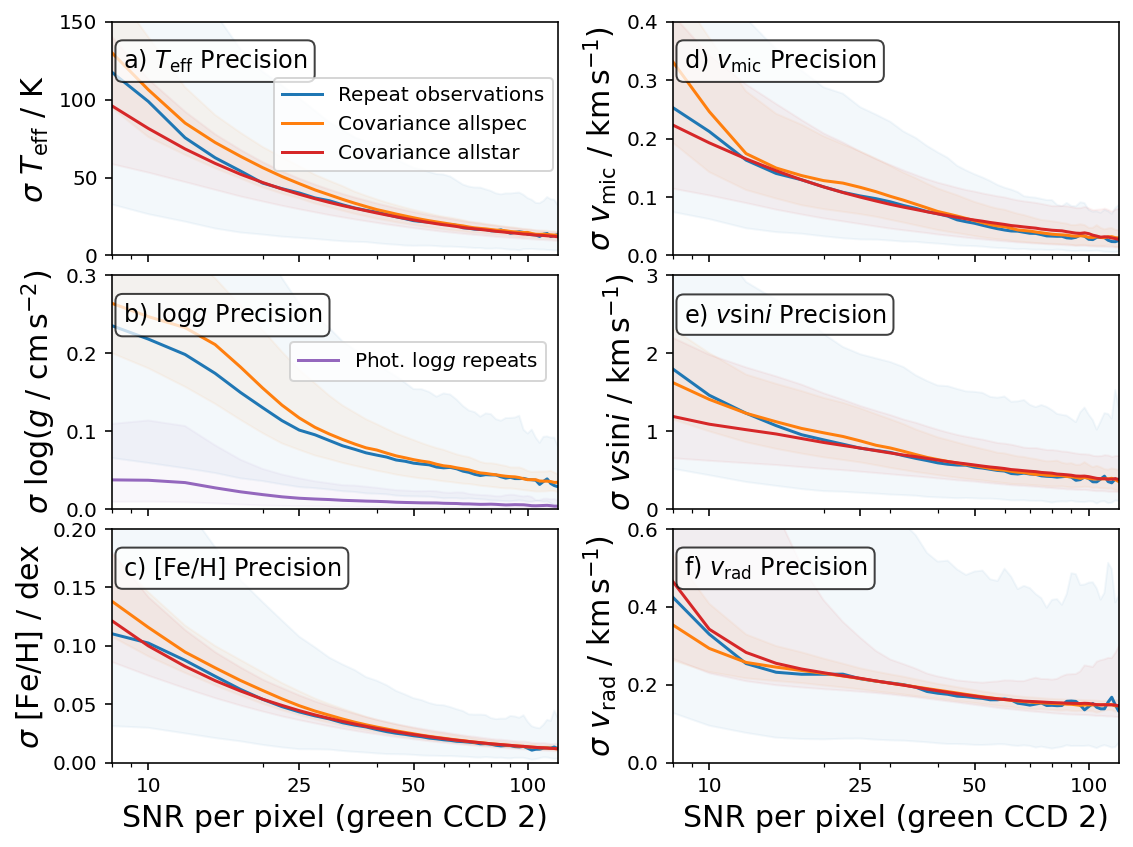

In [22]:
if setup == 'allstar':

    table_cov = dict()

    labels = ['teff','logg','fe_h','vmic','vsini','vrad']
    labels_nice = ['$T_\mathrm{eff}$','$\log g$','$\mathrm{[Fe/H]}$','$v_\mathrm{mic}$','$v \sin i$','$v_\mathrm{rad}$']
    panels = ['a)','b)','c)','d)','e)','f)']

    snr_bin_size  = 5
    snr_bins  = np.arange(snr_bin_size/2,200+snr_bin_size/2,snr_bin_size/2)

    f, gs = plt.subplots(3,2,figsize=(8,6),sharex=True)

    for label_index, label in enumerate(labels):

        if label_index < 3:
            ax = gs[label_index,0]
        else:
            ax = gs[label_index-3,1]

        ax.text(0.025,0.8,r''+panels[label_index]+' '+labels_nice[label_index]+' Precision',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

        percentiles = [16,50,84]

        for setup in ['allspec','allstar','repeats']:
            for percentile in percentiles:
                table_cov[setup+'_'+label+'_'+str(percentile)] = []
                if (label == 'logg') & (setup == 'repeats'):
                    table_cov[setup+'_'+label+'_phot_'+str(percentile)] = []

        for snr in snr_bins:

            # ALLSPEC
            in_bin = (
                (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
            )
            nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
            if nr_in_bin > 10:
                perc = np.nanpercentile(np.sqrt(repeat_data[label+'_cov'][in_bin]**2-accuracy_values[label]**2),q=percentiles)
                if label == 'logg':
                    perc = np.nanpercentile(np.sqrt(repeat_data[label+'_spec_cov'][in_bin]**2-accuracy_values[label]**2),q=percentiles)
            else:
                perc = [np.nan,np.nan,np.nan]
                if label == 'logg':
                    perc_phot = [np.nan,np.nan,np.nan]

            table_cov['allspec_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
            table_cov['allspec_'+label+'_'+str(percentiles[1])].append(perc[1])
            table_cov['allspec_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

            # ALLSTAR
            in_bin = (
                (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size)
            )
            nr_in_bin = len(galah_dr4_raw[label][in_bin])
            if nr_in_bin > 10:
                perc = np.nanpercentile(np.sqrt(galah_dr4_raw['e_'+label][in_bin]**2-accuracy_values[label]**2),q=percentiles)
            else:
                perc = [np.nan,np.nan,np.nan]
            table_cov['allstar_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
            table_cov['allstar_'+label+'_'+str(percentiles[1])].append(perc[1])
            table_cov['allstar_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

            # REPEATS
            in_bin = (
                (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
            )
            nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
            if nr_in_bin > 10:
                perc = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
                if label == 'logg':
                    perc = np.nanpercentile(repeat_data[label+'_spec_sigma'][in_bin],q=percentiles)
                    perc_phot = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
            else:
                perc = [np.nan,np.nan,np.nan]
                if label == 'logg':
                    perc_phot = [np.nan,np.nan,np.nan]
            table_cov['repeats_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
            table_cov['repeats_'+label+'_'+str(percentiles[1])].append(perc[1])
            table_cov['repeats_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])
            if label == 'logg':
                table_cov['repeats_'+label+'_phot_'+str(percentiles[0])].append(perc_phot[1]-perc_phot[0])
                table_cov['repeats_'+label+'_phot_'+str(percentiles[1])].append(perc_phot[1])
                table_cov['repeats_'+label+'_phot_'+str(percentiles[2])].append(perc_phot[2]-perc_phot[1])

        for setup in ['allspec','allstar','repeats']:
            for percentile in percentiles:
                table_cov[setup+'_'+label+'_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_'+str(percentile)])
                if (label == 'logg') & (setup == 'repeats'):
                    table_cov[setup+'_'+label+'_phot_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_phot_'+str(percentile)])

        for setup, color in zip(['repeats','allspec','allstar'],['C0','C1','C3']):

            if label_index == 0:
                if setup == 'allstar':
                    legend_label = 'Covariance allstar'
                if setup == 'allspec':
                    legend_label = 'Covariance allspec'
                if setup == 'repeats':
                    legend_label = 'Repeat observations'
            else:
                legend_label = '_nolegend_'

            ax.plot(
                snr_bins,
                table_cov[setup+'_'+label+'_50'],
                label = legend_label,
                color = color
            )
            ax.fill_between(
                snr_bins,
                table_cov[setup+'_'+label+'_50']-table_cov[setup+'_'+label+'_16'],
                table_cov[setup+'_'+label+'_50']+table_cov[setup+'_'+label+'_84'],
                label = '_nolegend_',
                alpha = 0.05,
                color = color
            )
        if label == 'logg':
            ax.plot(
                snr_bins,
                table_cov['repeats_'+label+'_phot_50'],
                label = r'Phot. $\log g$ repeats',
                color = 'C4'
            )
            ax.fill_between(
                snr_bins,
                table_cov['repeats_'+label+'_phot_50']-table_cov['repeats_'+label+'_phot_16'],
                table_cov['repeats_'+label+'_phot_50']+table_cov['repeats_'+label+'_phot_84'],
                label = '_nolegend_',
                alpha = 0.05,
                color = 'C4'
            )

        if label == 'teff':
            ax.set_ylim(0,150)
            ax.set_ylabel(r'$\sigma~T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
        elif label == 'logg':
            ax.set_ylim(0,0.3)
            ax.set_ylabel(r'$\sigma~\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
        elif label == 'fe_h':
            ax.set_ylim(0,0.2)
            ax.set_ylabel(r'$\sigma~\mathrm{[Fe/H]}~/~\mathrm{dex}$',fontsize=15)
        elif label == 'vmic':
            ax.set_ylim(0,0.4)
            ax.set_ylabel(r'$\sigma~v_\mathrm{mic}~/~\mathrm{km\,s^{-1}})$',fontsize=15)
        elif label == 'vsini':
            ax.set_ylim(0,3)
            ax.set_ylabel(r'$\sigma~v \sin i~/~\mathrm{km\,s^{-1}})$',fontsize=15)
        elif label == 'vrad':
            ax.set_ylim(0,0.6)
            ax.set_ylabel(r'$\sigma~v_\mathrm{rad}~/~\mathrm{km\,s^{-1}})$',fontsize=15)

        ax.set_xscale('log')
        ax.set_xlim(8,120)
        ax.set_xticks([10,25,50,100])
        ax.set_xticklabels([10,25,50,100])

        if label_index == 0:
            ax.legend(loc=(0.365,0.36))
        elif label_index == 1:
            ax.legend(loc=(0.4,0.55))
        if label_index in [2,5]:
            ax.set_xlabel(r'SNR per pixel (green CCD 2)',fontsize=15)

    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('figures/galah_dr4_precision_parameters.png',dpi=200,bbox_inches='tight')

Li
C
N
O
Na
Mg
Al
Si
K
Ca
Sc
Ti
V
Cr
Mn
Co
Ni
Cu
Zn
Rb


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Sr


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Y
Zr
Mo


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Ru


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Ba
La
Ce
Nd
Sm


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


Eu


/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


labels


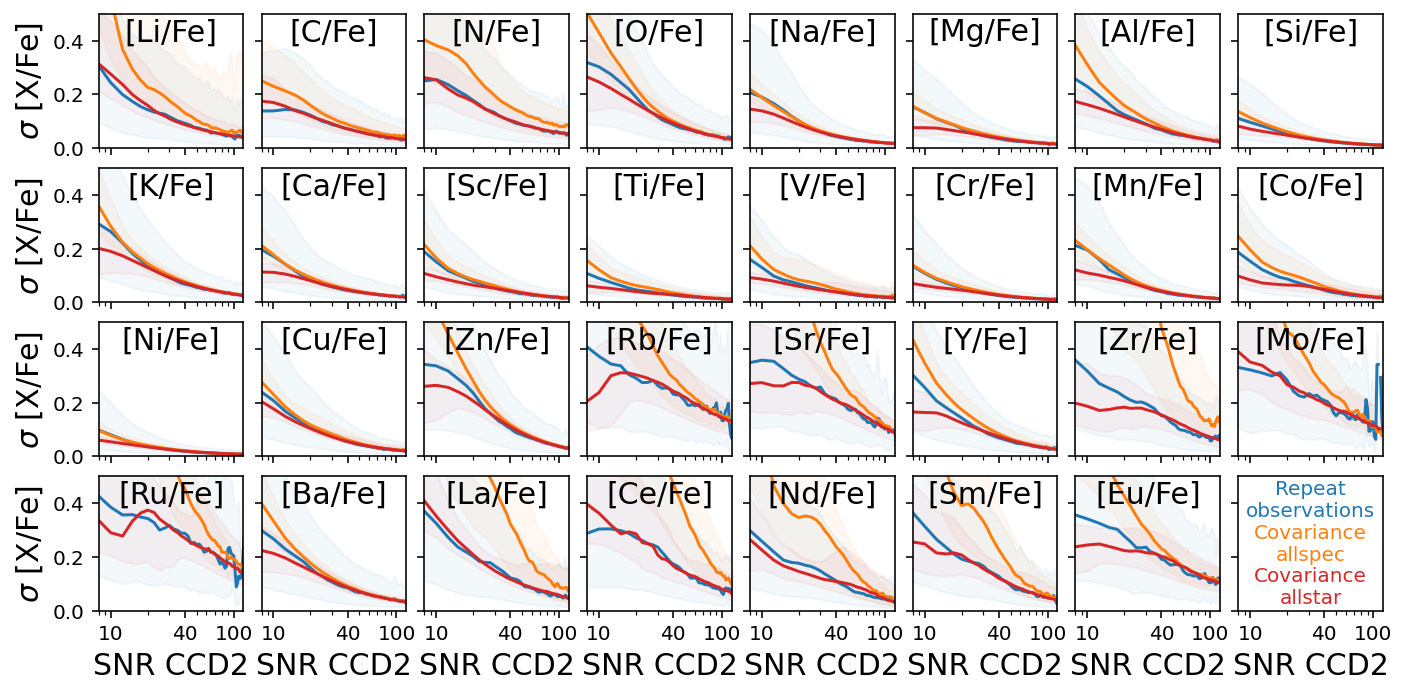

In [23]:
if setup == 'allstar':
    table_cov = dict()

    elements = [
            'Li','C','N','O',
            'Na','Mg','Al','Si',
            'K','Ca','Sc','Ti','V','Cr','Mn',#'Fe',
            'Co','Ni','Cu','Zn',
            'Rb','Sr','Y','Zr','Mo','Ru',
            'Ba','La','Ce','Nd','Sm','Eu','labels'
    ]

    snr_bin_size  = 5
    snr_bins  = np.arange(snr_bin_size/2,200+snr_bin_size/2,snr_bin_size/2)

    rows = 4
    columns = 8

    f, gs = plt.subplots(rows,columns,figsize=(10,5),sharex=True,sharey=True)

    for index, element in enumerate(elements):
        
        print(element)

        label = element.lower()+'_fe'

        row = int(np.floor(index/8))
        ax = gs[row,index-row*8]

        # Last panel has legend
        if element == 'labels':

            ax.text(0.5,0.825,'Repeat\nobservations',color='C0',ha='center',va='center',transform=ax.transAxes,fontsize=10)
            ax.text(0.5,0.5,'Covariance\nallspec',color='C1',ha='center',va='center',transform=ax.transAxes,fontsize=10)
            ax.text(0.5,0.175,'Covariance\nallstar',color='C3',ha='center',va='center',transform=ax.transAxes,fontsize=10)

        else:    
            ax.text(0.5,0.8,'['+element+'/Fe]',transform=ax.transAxes,fontsize=15,ha='center')

            percentiles = [16,50,84]

            for setup in ['allspec','allstar','repeats']:
                for percentile in percentiles:
                    table_cov[setup+'_'+label+'_'+str(percentile)] = []

            for snr in snr_bins:

                # ALLSPEC
                in_bin = (
                    (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                    (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
                )
                nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
                if nr_in_bin > 10:
                    perc = np.nanpercentile(repeat_data[label+'_cov'][in_bin],q=percentiles)
                else:
                    perc = [np.nan,np.nan,np.nan]
                    if label == 'logg':
                        perc_phot = [np.nan,np.nan,np.nan]

                table_cov['allspec_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
                table_cov['allspec_'+label+'_'+str(percentiles[1])].append(perc[1])
                table_cov['allspec_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

                # ALLSTAR
                in_bin = (
                    (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                    (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size) &
                    ((galah_dr4_raw['flag_sp'] == 0) | (galah_dr4_raw['flag_sp'] == 2048)) & 
                    (galah_dr4_raw['flag_'+label] == 0) & 
                    np.isfinite(galah_dr4_raw[label]) & 
                    np.isfinite(galah_dr4_raw['e_'+label])
                )
                nr_in_bin = len(galah_dr4_raw[label][in_bin])
                if nr_in_bin > 10:
                    perc = np.nanpercentile(galah_dr4_raw['e_'+label][in_bin],q=percentiles)
                else:
                    perc = [np.nan,np.nan,np.nan]
                table_cov['allstar_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
                table_cov['allstar_'+label+'_'+str(percentiles[1])].append(perc[1])
                table_cov['allstar_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

                # REPEATS
                in_bin = (
                    (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                    (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
                )
                nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
                if nr_in_bin > 10:
                    perc = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
                    if label == 'logg':
                        perc = np.nanpercentile(repeat_data[label+'_spec_sigma'][in_bin],q=percentiles)
                        perc_phot = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
                else:
                    perc = [np.nan,np.nan,np.nan]
                    if label == 'logg':
                        perc_phot = [np.nan,np.nan,np.nan]
                table_cov['repeats_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
                table_cov['repeats_'+label+'_'+str(percentiles[1])].append(perc[1])
                table_cov['repeats_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])
                if label == 'logg':
                    table_cov['repeats_'+label+'_phot_'+str(percentiles[0])].append(perc_phot[1]-perc_phot[0])
                    table_cov['repeats_'+label+'_phot_'+str(percentiles[1])].append(perc_phot[1])
                    table_cov['repeats_'+label+'_phot_'+str(percentiles[2])].append(perc_phot[2]-perc_phot[1])

            for setup in ['allspec','allstar','repeats']:
                for percentile in percentiles:
                    table_cov[setup+'_'+label+'_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_'+str(percentile)])
                    if (label == 'logg') & (setup == 'repeats'):
                        table_cov[setup+'_'+label+'_phot_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_phot_'+str(percentile)])

            for setup, color in zip(['repeats','allspec','allstar'],['C0','C1','C3']):

                if label_index == 0:
                    if setup == 'allstar':
                        legend_label = 'Covariance allstar'
                    if setup == 'allspec':
                        legend_label = 'Covariance allspec'
                    if setup == 'repeats':
                        legend_label = 'Repeat observations'
                else:
                    legend_label = '_nolegend_'

                ax.plot(
                    snr_bins,
                    table_cov[setup+'_'+label+'_50'],
                    label = legend_label,
                    color = color
                )
                ax.fill_between(
                    snr_bins,
                    table_cov[setup+'_'+label+'_50']-table_cov[setup+'_'+label+'_16'],
                    table_cov[setup+'_'+label+'_50']+table_cov[setup+'_'+label+'_84'],
                    label = '_nolegend_',
                    alpha = 0.05,
                    color = color
                )

            ax.set_xscale('log')
            ax.set_xlim(8,120)
            ax.set_xticks([10,40,100])
            ax.set_xticklabels([10,40,100])

            ax.set_ylim(0,0.5)

            if index-row*8 == 0:
                ax.set_ylabel(r'$\sigma~\mathrm{[X/Fe]}$',fontsize=15)

        if row+1==rows:
            ax.set_xlabel(r'SNR CCD2',fontsize=15)

    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('figures/galah_dr4_precision_abundances.png',dpi=200,bbox_inches='tight')

In [24]:
# raise ValueError('Should we rather check precision and accuracy of [X/H] than [X/Fe]?')

# PRECISION FOR OPEN / GLOBULAR CLUSTERS

In [ ]:
open_clusters = Table.read('../auxiliary_information/CantatGaudin_2020_AandA_640_1.fits')
open_clusters['gaiadr3_source_id'] = open_clusters['GaiaDR2']
open_clusters['cluster'] = open_clusters['Cluster']
dr4_oc = join(galah_dr4_raw, open_clusters, keys = 'gaiadr3_source_id')

In [ ]:
globular_clusters =Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_cluster_source_id_memberprob0p7.fits')
globular_clusters['gaiadr3_source_id'] = globular_clusters['source_id']
dr4_gc = join(galah_dr4_raw, globular_clusters, keys = 'gaiadr3_source_id')

In [ ]:
parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')

In [ ]:
multiple_stage_ocs = ['Collinder_261','NGC_2682','NGC_6253','Ruprecht_147','NGC_2112']#,'NGC_2204']

f, gs = plt.subplots(1,3,figsize=(15,3))

cmap = matplotlib.cm.get_cmap('plasma')

ax = gs[0]
for oc_index, oc in enumerate(multiple_stage_ocs):
    in_oc = np.where(dr4_oc['cluster']==oc)[0]
    
    a_v = np.round(np.nanmedian(dr4_oc['A_V'][in_oc]),3)
    age = np.round(np.nanmedian(dr4_oc['logAge'][in_oc]),3)

    if np.isnan(a_v):
        a_v = 0.0
        
    a_g_a_v = 0.83627; a_g = a_g_a_v * a_v
    a_bp_a_v = 1.08337; a_bp = a_bp_a_v * a_v
    a_rp_a_v  = 0.63439; a_rp = a_rp_a_v * a_v
    
    ax.scatter(
        dr4_oc['bp_rp'][in_oc] - (a_bp-a_rp),
        dr4_oc['phot_g_mean_mag'][in_oc] - 5*np.log10(dr4_oc['r_med_1'][in_oc]/10.) - a_g,
        color = cmap(oc_index/(len(multiple_stage_ocs))),
        s = 10,
        label = oc.replace('_',' ')
    )
ax.set_xlim(0.5,2.25)
ax.set_ylim(7,-2.5)
# ax.legend()

ax = gs[1]
for oc_index, oc in enumerate(multiple_stage_ocs):
    in_oc = np.where(dr4_oc['cluster']==oc)[0]
    ax.scatter(
        dr4_oc['teff'][in_oc],
        dr4_oc['logg'][in_oc],
        color = cmap(oc_index/(len(multiple_stage_ocs))),
        s = 10,
        label = oc.replace('_',' ')
    )
ax.set_xlim(8000,3500)
ax.set_ylim(5,0.5)
ax.legend(ncol=2)

ax = gs[2]
for oc_index, oc in enumerate(multiple_stage_ocs):
    in_oc = np.where(dr4_oc['cluster']==oc)[0]
    ax.scatter(
        dr4_oc['mass'][in_oc],
        dr4_oc['fe_h'][in_oc],
        color = cmap(oc_index/(len(multiple_stage_ocs))),
        s = 10,
        label = oc.replace('_',' ')
    )
ax.set_xlim(0.5,2)

plt.tight_layout()

In [ ]:
# oc_list = Table()
# oc_list['cluster'], oc_list['nr_stars'] = np.unique(dr4_oc['cluster'],return_counts=True)
# oc_list.sort('nr_stars',reverse=True)

# for oc in oc_list['cluster']:
    
#     a_v = np.round(np.nanmedian(dr4_oc['A_V'][dr4_oc['cluster']==oc]),3)
#     if np.isnan(a_v):
#         a_v = 0.0
        
#     a_g_a_v = 0.83627; a_g = a_g_a_v * a_v
#     a_bp_a_v = 1.08337; a_bp = a_bp_a_v * a_v
#     a_rp_a_v  = 0.63439; a_rp = a_rp_a_v * a_v
#     a_j_a_v  = 0.282; a_j = a_j_a_v * a_v
#     a_k_a_v  = 0.112; a_k = a_k_a_v * a_v
#     dr4_a_k = np.nanmedian(dr4_oc['a_ks'][dr4_oc['cluster']==oc])
#     dr4_ebv   = np.nanmedian(dr4_oc['ebv'][dr4_oc['cluster']==oc])

#     f, gs = plt.subplots(1,3,figsize=(10,3))
#     ax = gs[0]
#     ax.text(0.05,0.95,oc,va='top',ha='left',transform=ax.transAxes)
#     ax.scatter(
#         dr4_oc['bp_rp'][dr4_oc['cluster']==oc] - (a_bp - a_rp),
#         dr4_oc['phot_g_mean_mag'][dr4_oc['cluster']==oc] - a_g - 5*np.log10(dr4_oc['r_med_1'][dr4_oc['cluster']==oc]/10.),
#         c = 'grey', s = 5
#     )
#     ax.set_xlim(0,3)
#     ax.set_ylim(ax.get_ylim()[::-1])


#     dr4_age_perc = np.nanpercentile(dr4_oc['age'][dr4_oc['cluster']==oc],q=[16,50,84])
#     dr4_age_med = np.round(dr4_age_perc[1],3)
#     dr4_age_std = np.round(0.5*(age_perc[2]-dr4_age_perc[0]),3)
#     dr4_fe_h    = np.nanmedian(dr4_oc['fe_h'][dr4_oc['cluster']==oc])
#     dr4_mg_fe   = np.nanmedian(dr4_oc['mg_fe'][dr4_oc['cluster']==oc])

#     dr4_m_h = dr4_fe_h + np.log10(10**dr4_mg_fe * 0.694 + 0.306)
    
#     cg20_age    = np.round(10**(np.median(dr4_oc['logAge'][dr4_oc['cluster']==oc])-9.),3)
    
#     print(oc)
#     print('[Fe/H]  '+"{:.2f}".format(dr4_fe_h)+', [Mg/Fe] '+"{:.2f}".format(dr4_mg_fe)+', [M/H]  '+"{:.2f}".format(dr4_m_h))
#     print('Age (DR4)  ',dr4_age_med,'\pm',dr4_age_std)
#     print('Age (GC20) ',cg20_age)
#     print('A_V (GC20) ',a_v)
#     print('E(B-V)     ',dr4_ebv)
    
#     unique_parsec_age = np.unique(parsec['logAge'])
#     unique_parsec_m_h = np.unique(parsec['m_h'])
    
#     m_h_match_dr4 = np.argmin(abs(unique_parsec_m_h - dr4_m_h))
#     age_match_gc20 = np.argmin(abs(unique_parsec_age - np.median(dr4_oc['logAge'][dr4_oc['cluster']==oc])))
#     age_match_dr4 = np.argmin(abs(10**(unique_parsec_age-9) - age_perc[1]))
#     age_match_dr4_low = np.argmin(abs(10**(unique_parsec_age-9) - age_perc[0]))
#     age_match_dr4_high = np.argmin(abs(10**(unique_parsec_age-9) - age_perc[2]))
    
#     parsec_select_gc20 = (parsec['logAge'] == unique_parsec_age[age_match_gc20]) & (parsec['m_h'] == unique_parsec_m_h[m_h_match_dr4])
#     parsec_select_dr4 = (parsec['logAge'] == unique_parsec_age[age_match_dr4]) & (parsec['m_h'] == unique_parsec_m_h[m_h_match_dr4])
#     parsec_select_dr4_low = (parsec['logAge'] == unique_parsec_age[age_match_dr4_low]) & (parsec['m_h'] == unique_parsec_m_h[m_h_match_dr4])
#     parsec_select_dr4_high = (parsec['logAge'] == unique_parsec_age[age_match_dr4_high]) & (parsec['m_h'] == unique_parsec_m_h[m_h_match_dr4])
        
#     ax.plot(
#         parsec['GBPmag'][parsec_select_gc20]-parsec['GRPmag'][parsec_select_gc20],
#         parsec['Gmag'][parsec_select_gc20],
#         label = 'CG20 match', c = 'C0'
#     )
#     ax = gs[1]
#     ax.text(0.05,0.95,oc,va='top',ha='left',transform=ax.transAxes)
#     ax.scatter(
#         dr4_oc['j_m'][dr4_oc['cluster']==oc]-dr4_oc['ks_m'][dr4_oc['cluster']==oc] - (a_j - a_k),
#         dr4_oc['ks_m'][dr4_oc['cluster']==oc] - 5*np.log10(dr4_oc['r_med_1'][dr4_oc['cluster']==oc]/10.) - a_k,
#         c = 'grey', s = 5
#     )
#     ax.plot(
#         parsec['Jmag'][parsec_select_gc20]-parsec['Ksmag'][parsec_select_gc20],
#         parsec['Ksmag'][parsec_select_gc20],
#         label = 'CG20 match', c = 'C0'
#     )
#     ax.set_ylim(ax.get_ylim()[::-1])
    
#     ax = gs[2]
#     ax.text(0.05,0.95,oc,va='top',ha='left',transform=ax.transAxes)
#     ax.scatter(
#         dr4_oc['teff'][dr4_oc['cluster']==oc],
#         dr4_oc['logg'][dr4_oc['cluster']==oc],
#         c = 'grey', s = 5
#     )
#     ax.plot(
#         10**parsec['logT'][parsec_select_gc20],
#         parsec['logg'][parsec_select_gc20],
#         label = 'CG20 match', c = 'C0'
#     )
#     ax.set_xlim(ax.get_xlim()[::-1])
#     ax.set_ylim(ax.get_ylim()[::-1])
    
#     plt.show()
#     plt.close()

In [ ]:
gc_list = Table()
gc_list['cluster'], gc_list['nr_stars'] = np.unique(dr4_gc['cluster'],return_counts=True)
gc_list.sort('nr_stars',reverse=True)
gc_list

In [ ]:
top10_cluster_by_feh = [
    'NGC_104_47Tuc',
    'NGC_6362',
    'NGC_6121_M_4',
    'NGC_362',
    'NGC_288',
    'NGC_1851',
    'NGC_7089_M_2',
    'NGC_5139_oCen',
    'NGC_6397',
    'NGC_7099_M_30',
]

NGC_5139_oCen_JP10 = Table.read('literature_data/JohnsonPilachowski2010_ApJ_722_1373_OmegaCen_xmatch.fits')
Caretta09_Giraffe = Table.read('literature_data/Carretta2009_AandA_505_117_Giraffe.fits')
Caretta09_Uves = Table.read('literature_data/Carretta2009_AandA_505_139_UVES.fits')
Cordero14 = Table.read('literature_data/Cordero2014_ApJ_780_94_47Tuc_2MASS.fits')

f, gs = plt.subplots(10,3,figsize=(5,10))

for gc_index, gc in enumerate(top10_cluster_by_feh):

    in_gc = (dr4_gc['cluster']==gc) & ((dr4_gc['flag_sp']==0) | (dr4_gc['flag_sp']==2048))
    
    ax = gs[gc_index,0]

    ngc = gc.split('_')
    if len(ngc) == 2:
        ax.set_ylabel(gc.replace('_',' '))
    else:
        ax.set_ylabel(" ".join(ngc[2:])+'\n'+" ".join(ngc[:2]))

    if gc_index != 9:
        ax.set_xticks([])
    else:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
    ax.set_yticks([])
    
    ax.hist(
        dr4_gc['fe_h'][in_gc],
        bins = np.linspace(-2.5,-0.5,25),
        histtype='step',density=1,
        label = 'GALAH DR4',color='C0',
        zorder=5
    )
    
    ngc = int(gc.split('_')[1]) 

    xpos = 0.95; ha = 'right'
    if ngc in [104,6121,288]:
        xpos = 0.05; ha = 'left'
    
    if ngc in Caretta09_Giraffe['NGC']:
        star_in_ngc = np.where(Caretta09_Giraffe['NGC']==ngc)[0]
        ax.hist(
            Caretta09_Giraffe['__FeI_H_'][star_in_ngc],
            bins = np.linspace(-2.5,-0.5,25),
            histtype='step',density=1,
            label = 'C+ (2009) Giraffe',color='C1'
        )
        perc = np.percentile(Caretta09_Giraffe['__FeI_H_'][star_in_ngc],q=[16,50,84])
        ax.text(xpos,0.75,r'$'+"{:.2f}".format(perc[1])+'_{-'+"{:.2f}".format(perc[1]-perc[0])+'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}$',transform=ax.transAxes,ha=ha,va='top',color='C1')
    
    if ngc in Caretta09_Uves['NGC']:
        star_in_ngc = np.where(Caretta09_Uves['NGC']==ngc)[0]
        ax.hist(
            Caretta09_Uves['__FeI_H_'][star_in_ngc],
            bins = np.linspace(-2.5,-0.5,25),
            histtype='step',density=1,
            label = 'C+ (2009) Uves',color='C3'
        )
        perc = np.percentile(Caretta09_Uves['__FeI_H_'][star_in_ngc],q=[16,50,84])
        ax.text(xpos,0.95,r'$'+"{:.2f}".format(perc[1])+'_{-'+"{:.2f}".format(perc[1]-perc[0])+'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}$',transform=ax.transAxes,ha=ha,va='top',color='C3')

    if gc == 'NGC_5139_oCen':
        ax.hist(
            NGC_5139_oCen_JP10['__Fe_H_'],
            bins = np.linspace(-2.5,-0.5,25),
            histtype='step',density=1,
            label = 'J&P (2010)', color='C2'
        )
        perc = np.percentile(NGC_5139_oCen_JP10['__Fe_H_'],q=[16,50,84])
        ax.text(0.95,0.95,r'$'+"{:.2f}".format(perc[1])+'_{-'+"{:.2f}".format(perc[1]-perc[0])+'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}$',transform=ax.transAxes,ha='right',va='top',color='C2')
        
    
    ax = gs[gc_index,1]
    ax.scatter(
        dr4_gc['teff'][in_gc],
        dr4_gc['logg'][in_gc],
        c = dr4_gc['fe_h'][in_gc],
        s = 2, cmap = 'plasma',
        vmin = -2.5, vmax = -0.5
    )
    ax.set_xlim(5650,3650)
    ax.set_ylim(3.75,0.25)
    ax.set_ylabel(r'$\log g$')
    
    if gc_index != 9:
        ax.set_xticks([])
    else:
        ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$')
    
    ax = gs[gc_index,2]
    ax.scatter(
        dr4_gc['bp_rp'][in_gc],
        dr4_gc['phot_g_mean_mag'][in_gc]-5*np.log10(dr4_gc['r_med'][in_gc]/10),
        c = dr4_gc['fe_h'][in_gc],
        s = 2, cmap = 'plasma',
        vmin = -2.5, vmax = -0.5
    )
    perc = np.percentile(dr4_gc['fe_h'][in_gc],q=[16,50,84])
    ax.text(0.95,0.05,r'$'+"{:.2f}".format(perc[1])+'_{-'+"{:.2f}".format(perc[1]-perc[0])+'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}$',transform=ax.transAxes,ha='right',va='bottom',color='C0')
    ax.set_xlim(0.75,2.25)
    ax.set_ylim(3.75,-3.5)
    ax.set_ylabel(r'$M_G~/~\mathrm{mag}$')
    ax.set_yticks([-2,0,2])
    
    if gc_index != 9:
        ax.set_xticks([])
    else:
        ax.set_xlabel(r'$G_{BP} - G_{RP}~/~\mathrm{mag}$')

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/galah_dr4_allstar_globular_cluster_feh_comparison.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Extra Checks

In [ ]:
nissen2010 = ['07434398-0004006','03402202-0313005','08584388-1607583']
das2020 = ['04111768+2322358','04171078+2318325','08305997-0035215','08364038+1654224','08401271+1146062','08503181+1054192','11363504+0419133','12480602-0702221','16504008-1925050','21331406-0053534','21343149-0056169']

In [ ]:
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [ ]:
for tmass_id in np.concatenate((nissen2010,das2020)):
    matches = np.where(tmass_id == galah_dr4_raw['tmass_id'])[0]
    if len(matches) > 0:
        for match in matches:
            print(galah_dr4_raw['sobject_id'][match],galah_dr4_raw['tmass_id'][match],np.round(galah_dr4_raw['fe_h'][match],2))
            fitted = []
            not_fitted = []
            for element in [
                'Li','C','N','O',
                'Na','Mg','Al','Si',
                'K','Ca','Sc','Ti','V','Cr','Mn',
                'Co','Ni','Cu','Zn',
                'Rb','Sr','Y','Zr','Mo','Ru',
                'Ba','La','Ce','Nd','Sm','Eu'
            ]:
                if galah_dr4_raw['flag_'+element.lower()+'_fe'][match] != 2:
                    fitted.append(element)
                else:
                    not_fitted.append(element)
            print('fitted: ',fitted)
            print('not fitted: ',not_fitted)
            print(galah_dr4_raw['closest_model'][match],galah_dr4_raw['model_name'][match],grids['index_subgrid'][grids['model_name']==galah_dr4_raw['model_name'][match]][0])
            
            print('get_dr4 '+str(galah_dr4_raw['sobject_id'][match])[:6]+' '+str(galah_dr4_raw['sobject_id'][match]))
            print('')
    else:
        print('No match for ',matches)

# Covariance Matrices

In [ ]:
vesta_cov = np.load('../analysis_products/210115/210115002201239/210115002201239_single_fit_covariances.npz',allow_pickle=True)
arcturus_cov = np.load('../analysis_products/150210/150210005801171/150210005801171_single_fit_covariances.npz')
# if you need to see what keywords are in the file:
# vesta_cov.files
# ['model_labels', 'model_name', 'model_parameters', 'model_covariances']

In [ ]:
f, ax = plt.subplots(figsize=(10,10))

diag = vesta_cov['model_covariances']
# Null the diagonal entries
diag[np.arange(len(diag)),np.arange(len(diag))] = 0.
p95 = np.percentile(np.abs(diag),q=95)

s = ax.imshow(
    diag,
    cmap = 'seismic',
    vmin = -p95,
    vmax = p95,
)

ax.set_xticks(np.arange(len(vesta_cov['model_labels'])))
ax.set_xticklabels(vesta_cov['model_labels'],rotation=90,fontsize=15)
ax.set_yticks(np.arange(len(vesta_cov['model_labels'])))
ax.set_yticklabels(vesta_cov['model_labels'],fontsize=15)
cbar = plt.colorbar(s,ax=ax,extend='both',fraction=0.04, pad=0.04)
cbar.set_label('Covariance value for VESTA / 210115002201239',fontsize=15)
plt.tight_layout()
plt.savefig('figures/covariance_vesta.png',dpi=200,bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(10,10))

diag = arcturus_cov['model_covariances']
# Null the diagonal entries
diag[np.arange(len(diag)),np.arange(len(diag))] = 0.
p95 = np.percentile(np.abs(diag),q=95)

s = ax.imshow(
    diag,
    cmap = 'seismic',
    vmin = -p95,
    vmax = p95,
)

ax.set_xticks(np.arange(len(arcturus_cov['model_labels'])))
ax.set_xticklabels(arcturus_cov['model_labels'],rotation=90,fontsize=15)
ax.set_yticks(np.arange(len(arcturus_cov['model_labels'])))
ax.set_yticklabels(arcturus_cov['model_labels'],fontsize=15)
cbar = plt.colorbar(s,ax=ax,extend='both',fraction=0.04, pad=0.04)
cbar.set_label('Covariance value for Arcturus / 150210005801171',fontsize=15)
plt.tight_layout()
plt.savefig('figures/covariance_arcturus.png',dpi=200,bbox_inches='tight')